# AI-Enhanced Robo Advisor: LSTM for Indian Stock Price Prediction

## MTech Project - Financial Time Series Analysis (2015-2025)

### Project Overview
This notebook implements a comprehensive LSTM-based robo-advisor for predicting Indian stock prices with:
- **Data**: Indian stocks (Nifty 50 components) from 2015-2025
- **Model**: LSTM (Long Short-Term Memory time series forecasting)
- **Features**: Technical indicators, price patterns, and market features
- **Evaluation**: Comprehensive metrics and visualizations
- **Deployment**: Model saving and monitoring utilities

### Table of Contents
1. Environment Setup & Imports
2. Data Download & Preparation
3. Data Cleaning & Preprocessing
4. Feature Engineering
5. LSTM Model Development
6. Model Training & Validation
7. Model Evaluation & Metrics
8. Visualizations & Analysis
9. Model Deployment
10. Model Monitoring
11. Results & Conclusions


## 1. Environment Setup & Imports


In [23]:
# Install required packages (run once)
#!pip install yfinance pandas numpy matplotlib seaborn scikit-learn torch torchvision tqdm plotly dash jupyter-dash

# Core imports
import os
import math
import time
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Financial data
import yfinance as yf

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Utilities
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✅ All packages imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [24]:
# Configuration Parameters
print("🔄 Setting up configuration for stock-specific training...")

# Import required libraries
import pandas as pd
import numpy as np
import torch

# Define CONFIG with base parameters first
CONFIG = {
    # Data Configuration
    'tickers': [
        'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
        'HINDUNILVR.NS', 'ITC.NS', 'KOTAKBANK.NS', 'LT.NS', 'BHARTIARTL.NS'
    ],
    'start_date': '2015-01-01',
    'end_date': '2025-01-01',
    'target_col': 'Close',

    # Stock-Specific Training Configuration
    'stock_specific_training': True,    # Enable stock-specific training
    'train_years': 7,                   # 7 years for training (2015-2022)
    'val_years': 1.5,                   # 1.5 years for validation (2022-2023.5)
    'test_years': 1.5,                  # 1.5 years for testing (2023.5-2025)

    # Base Model Configuration
    'sequence_length': 60,      # Lookback window (days)
    'forecast_horizon': 5,      # Prediction horizon (days)
    'batch_size': 32,
    'epochs': 2,
    'learning_rate': 1e-4,
    'patience': 15,             # Early stopping patience

    # LSTM Architecture
    'lstm_hidden_size': 256,      # Hidden state dimension
    'lstm_num_layers': 3,          # Number of stacked LSTM layers
    'lstm_dropout': 0.2,           # Dropout between LSTM layers
    'lstm_bidirectional': True,    # Use bidirectional LSTM for better accuracy

    # Base Training Configuration
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'test_ratio': 0.15,

    # Base Feature Configuration
    'max_features': 15,                 # Maximum number of features per stock
    'selected_features': [             # Core technical indicators
        'Close', 'Volume', 'Returns', 'Volatility',
        'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal',
        'BB_Upper', 'BB_Lower', 'ATR_14', 'Stoch_K', 'Stoch_D',
        'Williams_R', 'CCI_14'
    ],

    # Base Paths
    'data_dir': 'data',
    'model_dir': 'models',
    'results_dir': 'results',
    'logs_dir': 'logs',

    # Device Configuration
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print("✅ Configuration updated successfully!")
print(f"🎯 Stock-specific training: {CONFIG['stock_specific_training']}")
print(f"📅 Training period: {CONFIG['train_years']} years")
print(f"📅 Validation period: {CONFIG['val_years']} years")
print(f"📅 Test period: {CONFIG['test_years']} years")
print(f"📊 Sequence length: {CONFIG['sequence_length']} days")
print(f"🔧 Max features per stock: {CONFIG['max_features']}")
print(f"📈 Selected features: {len(CONFIG['selected_features'])}")


🔄 Setting up configuration for stock-specific training...
✅ Configuration updated successfully!
🎯 Stock-specific training: True
📅 Training period: 7 years
📅 Validation period: 1.5 years
📅 Test period: 1.5 years
📊 Sequence length: 60 days
🔧 Max features per stock: 15
📈 Selected features: 16


## 2. Data Download & Preparation


In [25]:
def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Download stock data for a given ticker and date range

    Args:
        ticker: Stock ticker symbol
        start_date: Start date in YYYY-MM-DD format
        end_date: End date in YYYY-MM-DD format

    Returns:
        DataFrame with stock data
    """
    try:
        logger.info(f"Downloading data for {ticker} from {start_date} to {end_date}")
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)

        if data.empty:
            logger.warning(f"No data found for {ticker}")
            return pd.DataFrame()

        # Reset index to make Date a column
        data.reset_index(inplace=True)
        data['Ticker'] = ticker
        data['Date'] = pd.to_datetime(data['Date'])

        # Add basic price features
        data['Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
        data['Volatility'] = data['Returns'].rolling(window=20).std()

        # Ensure we have all required columns
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in required_cols:
            if col not in data.columns:
                logger.warning(f"⚠️ Missing column {col} for {ticker}, skipping...")
                return pd.DataFrame()

        # Add Adj Close if missing
        if 'Adj Close' not in data.columns:
            data['Adj Close'] = data['Close']

        logger.info(f"✅ Downloaded {len(data)} records for {ticker}")
        return data

    except Exception as e:
        logger.error(f"❌ Error downloading {ticker}: {str(e)}")
        return pd.DataFrame()

def download_all_stocks(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    """
    Download data for all tickers and combine into single DataFrame
    """
    all_data = []

    for ticker in tqdm(tickers, desc="Downloading stock data"):
        data = download_stock_data(ticker, start_date, end_date)
        if not data.empty:
            all_data.append(data)
        time.sleep(0.1)  # Rate limiting

    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        logger.info(f"📊 Total records downloaded: {len(combined_data)}")
        return combined_data
    else:
        logger.error("❌ No data downloaded")
        return pd.DataFrame()

# Download data
print("🚀 Starting data download...")
raw_data = download_all_stocks(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'])

if not raw_data.empty:
    print(f"✅ Data download completed!")
    print(f"📊 Shape: {raw_data.shape}")
    print(f"📅 Date range: {raw_data['Date'].min()} to {raw_data['Date'].max()}")
    print(f"🏢 Stocks: {raw_data['Ticker'].nunique()}")
    print(f"📈 Columns: {list(raw_data.columns)}")

    # Display sample data
    print("\n📋 Sample data:")
    display(raw_data.head())

    # Save raw data
    raw_data.to_csv(f"{CONFIG['data_dir']}/raw_stock_data.csv", index=False)
    print(f"💾 Raw data saved to {CONFIG['data_dir']}/raw_stock_data.csv")
else:
    print("❌ Data download failed!")


🚀 Starting data download...


INFO:__main__:✅ Downloaded 2467 records for RELIANCE.NS
INFO:__main__:✅ Downloaded 2467 records for TCS.NS
INFO:__main__:✅ Downloaded 2467 records for INFY.NS
INFO:__main__:✅ Downloaded 2467 records for HDFCBANK.NS
INFO:__main__:✅ Downloaded 2467 records for ICICIBANK.NS
INFO:__main__:✅ Downloaded 2467 records for HINDUNILVR.NS
INFO:__main__:✅ Downloaded 2467 records for ITC.NS
INFO:__main__:✅ Downloaded 2467 records for KOTAKBANK.NS
INFO:__main__:✅ Downloaded 2467 records for LT.NS
INFO:__main__:✅ Downloaded 2467 records for BHARTIARTL.NS
INFO:__main__:📊 Total records downloaded: 24670


✅ Data download completed!
📊 Shape: (24670, 13)
📅 Date range: 2015-01-01 00:00:00+05:30 to 2024-12-31 00:00:00+05:30
🏢 Stocks: 10
📈 Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Ticker', 'Returns', 'Log_Returns', 'Volatility', 'Adj Close']

📋 Sample data:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Returns,Log_Returns,Volatility,Adj Close
0,2015-01-01 00:00:00+05:30,189.657461,190.877186,189.090381,189.999832,2963643,0.0,0.0,RELIANCE.NS,NaN,NaN,NaN,189.999832
1,2015-01-02 00:00:00+05:30,190.042616,191.743828,189.229471,189.496948,7331366,0.0,0.0,RELIANCE.NS,-0.002647,-0.002650,NaN,189.496948
2,2015-01-05 00:00:00+05:30,189.379239,190.641775,187.046767,187.421249,10103941,0.0,0.0,RELIANCE.NS,-0.010954,-0.011014,NaN,187.421249
3,2015-01-06 00:00:00+05:30,186.169417,186.811376,178.037869,178.915222,18627980,0.0,0.0,RELIANCE.NS,-0.045385,-0.046447,NaN,178.915222
4,2015-01-07 00:00:00+05:30,179.129258,183.772792,179.107860,182.809845,20720312,0.0,0.0,RELIANCE.NS,0.021768,0.021534,NaN,182.809845


💾 Raw data saved to data/raw_stock_data.csv


## 3. Data Cleaning & Preprocessing


INFO:__main__:🧹 Starting data cleaning...
INFO:__main__:🔧 Missing values: 220 → 220
INFO:__main__:🔍 Performing data quality checks...
INFO:__main__:✅ Data cleaning completed! Final shape: (24670, 21)


📊 Data cleaning summary:
   Original records: 24,670
   Cleaned records: 24,670
   Records removed: 0
   Stocks: 10
   Date range: 2015-01-01 to 2024-12-31

📋 Sample of cleaned data:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Returns,...,Volatility,Adj Close,Daily_Change,Year,Month,Day,DayOfWeek,Quarter,IsMonthEnd,IsQuarterEnd
0,2015-01-01 00:00:00+05:30,300.857757,309.771427,298.523226,308.073578,2460188,0.0,0.0,BHARTIARTL.NS,NaN,...,NaN,308.073578,NaN,2015,1,1,3,1,False,False
1,2015-01-02 00:00:00+05:30,308.837577,311.554134,307.309527,309.898743,2795887,0.0,0.0,BHARTIARTL.NS,0.005924,...,NaN,309.898743,0.005924,2015,1,2,4,1,False,False
2,2015-01-05 00:00:00+05:30,310.917481,310.917481,301.876469,303.022491,1605267,0.0,0.0,BHARTIARTL.NS,-0.022189,...,NaN,303.022491,-0.022189,2015,1,5,0,1,False,False
3,2015-01-06 00:00:00+05:30,302.300899,302.300899,295.764190,300.645508,3916948,0.0,0.0,BHARTIARTL.NS,-0.007844,...,NaN,300.645508,-0.007844,2015,1,6,1,1,False,False
4,2015-01-07 00:00:00+05:30,298.777820,303.913822,297.546912,301.367035,4899318,0.0,0.0,BHARTIARTL.NS,0.002400,...,NaN,301.367035,0.002400,2015,1,7,2,1,False,False
5,2015-01-08 00:00:00+05:30,302.682884,308.115970,299.796528,306.587921,7096620,0.0,0.0,BHARTIARTL.NS,0.017324,...,NaN,306.587921,0.017324,2015,1,8,3,1,False,False
6,2015-01-09 00:00:00+05:30,307.734006,309.771424,300.475728,302.046234,3831782,0.0,0.0,BHARTIARTL.NS,-0.014814,...,NaN,302.046234,-0.014814,2015,1,9,4,1,False,False
7,2015-01-12 00:00:00+05:30,301.961369,301.961369,294.660634,296.231140,2276975,0.0,0.0,BHARTIARTL.NS,-0.019252,...,NaN,296.231140,-0.019252,2015,1,12,0,1,False,False
8,2015-01-13 00:00:00+05:30,297.037604,299.075022,292.283656,293.981476,1604173,0.0,0.0,BHARTIARTL.NS,-0.007594,...,NaN,293.981476,-0.007594,2015,1,13,1,1,False,False
9,2015-01-14 00:00:00+05:30,294.533227,295.594364,292.580694,293.556946,3415213,0.0,0.0,BHARTIARTL.NS,-0.001444,...,NaN,293.556946,-0.001444,2015,1,14,2,1,False,False


💾 Cleaned data saved to data/cleaned_stock_data.csv


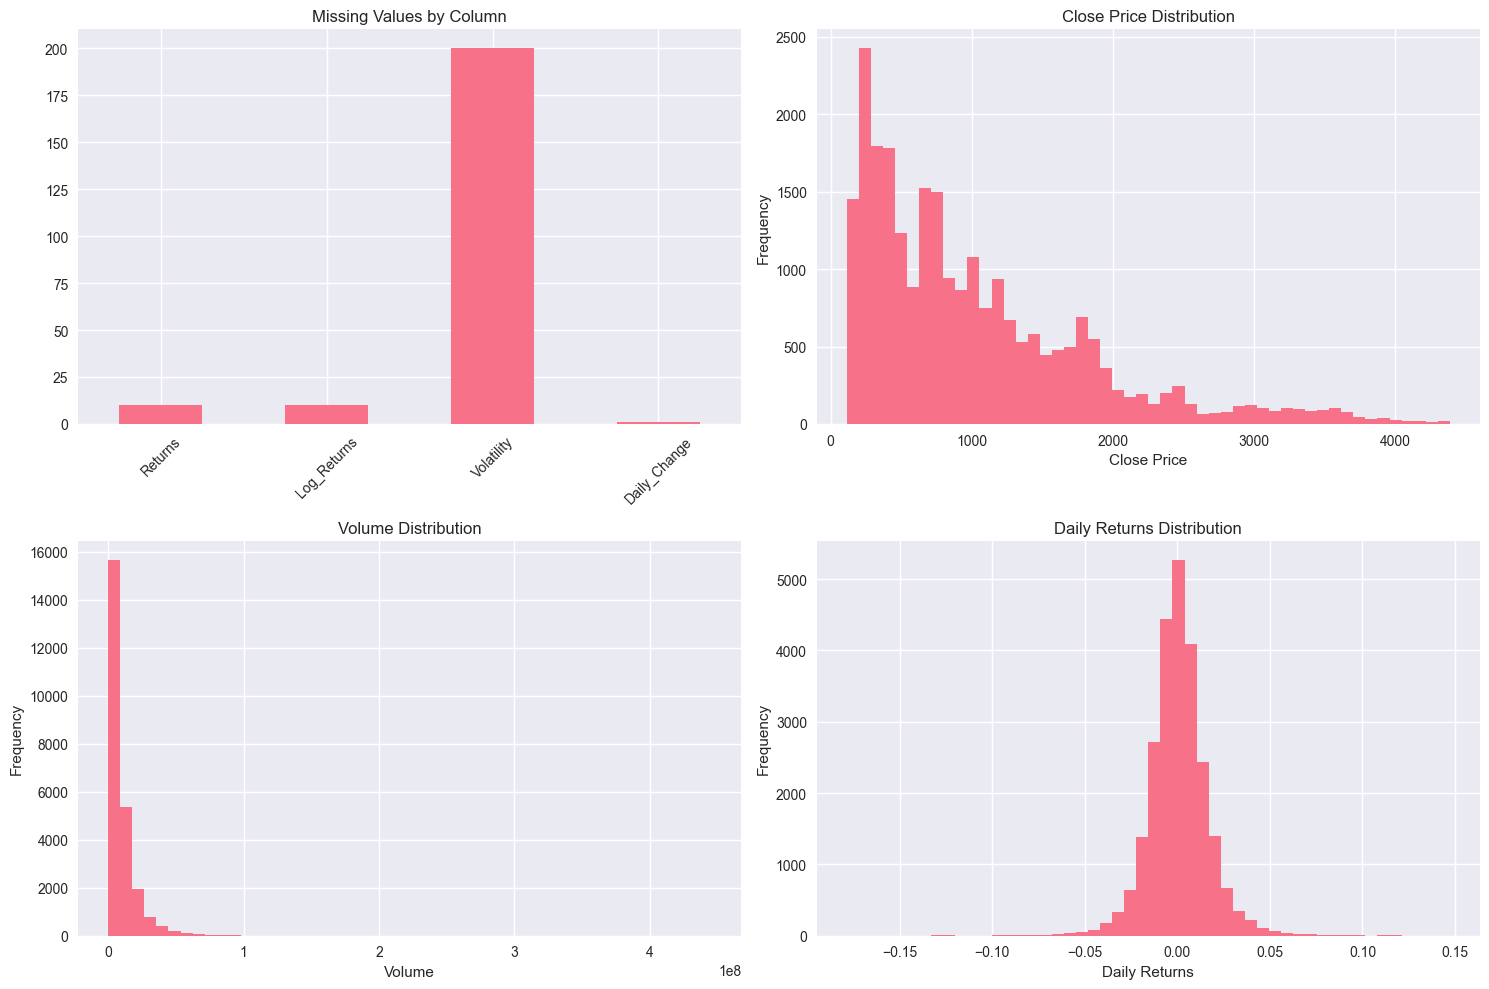

In [26]:
def clean_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and preprocess stock data

    Args:
        df: Raw stock data DataFrame

    Returns:
        Cleaned DataFrame
    """
    logger.info("🧹 Starting data cleaning...")

    # Create a copy to avoid modifying original
    cleaned_df = df.copy()

    # Sort by ticker and date
    cleaned_df = cleaned_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    # Add missing 'Adj Close' column if it doesn't exist (use 'Close' as fallback)
    if 'Adj Close' not in cleaned_df.columns and 'Close' in cleaned_df.columns:
        cleaned_df['Adj Close'] = cleaned_df['Close']
        logger.info("📊 Added 'Adj Close' column using 'Close' prices as fallback")

    # Check for minimum required columns
    required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    missing_required = [col for col in required_cols if col not in cleaned_df.columns]
    if missing_required:
        logger.error(f"❌ Missing required columns: {missing_required}")
        return pd.DataFrame()  # Return empty DataFrame if critical columns are missing

    # Remove duplicates
    initial_rows = len(cleaned_df)
    cleaned_df = cleaned_df.drop_duplicates(subset=['Ticker', 'Date']).reset_index(drop=True)
    removed_duplicates = initial_rows - len(cleaned_df)
    if removed_duplicates > 0:
        logger.info(f"🗑️ Removed {removed_duplicates} duplicate records")

    # Handle missing values
    missing_before = cleaned_df.isnull().sum().sum()

    # Forward fill missing values for each ticker
    for ticker in cleaned_df['Ticker'].unique():
        ticker_mask = cleaned_df['Ticker'] == ticker
        ticker_data = cleaned_df[ticker_mask]

        # Forward fill price and volume data - only for columns that exist
        price_volume_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        available_cols = [col for col in price_volume_cols if col in ticker_data.columns]

        for col in available_cols:
            cleaned_df.loc[ticker_mask, col] = ticker_data[col].fillna(method='ffill')

        # Fill remaining NaN with backward fill - only for available columns
        if available_cols:
            cleaned_df.loc[ticker_mask, available_cols] = cleaned_df.loc[ticker_mask, available_cols].fillna(method='bfill')

    # Remove rows with still missing critical data - only for columns that exist
    critical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    available_critical_cols = [col for col in critical_cols if col in cleaned_df.columns]
    if available_critical_cols:
        cleaned_df = cleaned_df.dropna(subset=available_critical_cols)

    missing_after = cleaned_df.isnull().sum().sum()
    logger.info(f"🔧 Missing values: {missing_before} → {missing_after}")

    # Data quality checks
    logger.info("🔍 Performing data quality checks...")

    # Check for negative prices - only for columns that exist
    price_cols = ['Open', 'High', 'Low', 'Close']
    available_price_cols = [col for col in price_cols if col in cleaned_df.columns]
    if available_price_cols:
        negative_prices = (cleaned_df[available_price_cols] < 0).any(axis=1).sum()
        if negative_prices > 0:
            logger.warning(f"⚠️ Found {negative_prices} records with negative prices")

    # Check for zero volume
    zero_volume = (cleaned_df['Volume'] == 0).sum()
    if zero_volume > 0:
        logger.warning(f"⚠️ Found {zero_volume} records with zero volume")

    # Check for unrealistic price movements (>50% daily change)
    cleaned_df['Daily_Change'] = cleaned_df['Close'].pct_change()
    extreme_moves = (abs(cleaned_df['Daily_Change']) > 0.5).sum()
    if extreme_moves > 0:
        logger.warning(f"⚠️ Found {extreme_moves} records with extreme price movements (>50%)")

    # Remove extreme outliers (optional - be careful with this)
    # cleaned_df = cleaned_df[abs(cleaned_df['Daily_Change']) <= 0.5]

    # Add date features
    cleaned_df['Year'] = cleaned_df['Date'].dt.year
    cleaned_df['Month'] = cleaned_df['Date'].dt.month
    cleaned_df['Day'] = cleaned_df['Date'].dt.day
    cleaned_df['DayOfWeek'] = cleaned_df['Date'].dt.dayofweek
    cleaned_df['Quarter'] = cleaned_df['Date'].dt.quarter
    cleaned_df['IsMonthEnd'] = cleaned_df['Date'].dt.is_month_end
    cleaned_df['IsQuarterEnd'] = cleaned_df['Date'].dt.is_quarter_end

    logger.info(f"✅ Data cleaning completed! Final shape: {cleaned_df.shape}")
    return cleaned_df

# Clean the data
if not raw_data.empty:
    cleaned_data = clean_stock_data(raw_data)

    # Display cleaning results
    print(f"📊 Data cleaning summary:")
    print(f"   Original records: {len(raw_data):,}")
    print(f"   Cleaned records: {len(cleaned_data):,}")
    print(f"   Records removed: {len(raw_data) - len(cleaned_data):,}")
    print(f"   Stocks: {cleaned_data['Ticker'].nunique()}")
    print(f"   Date range: {cleaned_data['Date'].min().date()} to {cleaned_data['Date'].max().date()}")

    # Display sample of cleaned data
    print("\n📋 Sample of cleaned data:")
    display(cleaned_data.head(10))

    # Save cleaned data
    cleaned_data.to_csv(f"{CONFIG['data_dir']}/cleaned_stock_data.csv", index=False)
    print(f"💾 Cleaned data saved to {CONFIG['data_dir']}/cleaned_stock_data.csv")

    # Data quality visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Missing values heatmap
    missing_data = cleaned_data.isnull().sum()
    if missing_data.sum() > 0:
        missing_data[missing_data > 0].plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Missing Values by Column')
        axes[0,0].tick_params(axis='x', rotation=45)
    else:
        axes[0,0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Missing Values Check')

    # Price distribution
    cleaned_data['Close'].hist(bins=50, ax=axes[0,1])
    axes[0,1].set_title('Close Price Distribution')
    axes[0,1].set_xlabel('Close Price')
    axes[0,1].set_ylabel('Frequency')

    # Volume distribution
    cleaned_data['Volume'].hist(bins=50, ax=axes[1,0])
    axes[1,0].set_title('Volume Distribution')
    axes[1,0].set_xlabel('Volume')
    axes[1,0].set_ylabel('Frequency')

    # Daily returns distribution
    cleaned_data['Returns'].hist(bins=50, ax=axes[1,1])
    axes[1,1].set_title('Daily Returns Distribution')
    axes[1,1].set_xlabel('Daily Returns')
    axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

else:
    print("❌ No data available for cleaning!")


## 4. Feature Engineering


In [27]:
def calculate_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate comprehensive technical indicators for stock data

    Args:
        df: DataFrame with stock data

    Returns:
        DataFrame with technical indicators
    """
    logger.info("🔧 Calculating technical indicators...")

    result_df = df.copy()

    # Price-based indicators (with min_periods to reduce NaN values)
    result_df['SMA_5'] = result_df['Close'].rolling(window=5, min_periods=1).mean()
    result_df['SMA_10'] = result_df['Close'].rolling(window=10, min_periods=1).mean()
    result_df['SMA_20'] = result_df['Close'].rolling(window=20, min_periods=1).mean()
    result_df['SMA_50'] = result_df['Close'].rolling(window=50, min_periods=1).mean()
    result_df['SMA_200'] = result_df['Close'].rolling(window=200, min_periods=1).mean()

    # Exponential Moving Averages
    result_df['EMA_12'] = result_df['Close'].ewm(span=12, adjust=False).mean()
    result_df['EMA_26'] = result_df['Close'].ewm(span=26, adjust=False).mean()
    result_df['EMA_50'] = result_df['Close'].ewm(span=50, adjust=False).mean()

    # MACD
    result_df['MACD'] = result_df['EMA_12'] - result_df['EMA_26']
    result_df['MACD_Signal'] = result_df['MACD'].ewm(span=9, adjust=False).mean()
    result_df['MACD_Histogram'] = result_df['MACD'] - result_df['MACD_Signal']

    # Bollinger Bands (with min_periods)
    result_df['BB_Middle'] = result_df['Close'].rolling(window=20, min_periods=1).mean()
    bb_std = result_df['Close'].rolling(window=20, min_periods=1).std()
    result_df['BB_Upper'] = result_df['BB_Middle'] + (bb_std * 2)
    result_df['BB_Lower'] = result_df['BB_Middle'] - (bb_std * 2)
    result_df['BB_Width'] = result_df['BB_Upper'] - result_df['BB_Lower']
    result_df['BB_Position'] = (result_df['Close'] - result_df['BB_Lower']) / (result_df['BB_Upper'] - result_df['BB_Lower'] + 1e-8)

    # RSI (Relative Strength Index) - with min_periods
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / (loss + 1e-8)  # Add small value to avoid division by zero
        rsi = 100 - (100 / (1 + rs))
        return rsi

    result_df['RSI_14'] = calculate_rsi(result_df['Close'], 14)
    result_df['RSI_21'] = calculate_rsi(result_df['Close'], 21)

    # Stochastic Oscillator - with min_periods
    def calculate_stochastic(high, low, close, k_window=14, d_window=3):
        lowest_low = low.rolling(window=k_window, min_periods=1).min()
        highest_high = high.rolling(window=k_window, min_periods=1).max()
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low + 1e-8))
        d_percent = k_percent.rolling(window=d_window, min_periods=1).mean()
        return k_percent, d_percent

    result_df['Stoch_K'], result_df['Stoch_D'] = calculate_stochastic(
        result_df['High'], result_df['Low'], result_df['Close']
    )

    # Williams %R - with min_periods
    result_df['Williams_R'] = -100 * (result_df['High'].rolling(window=14, min_periods=1).max() - result_df['Close']) / (result_df['High'].rolling(window=14, min_periods=1).max() - result_df['Low'].rolling(window=14, min_periods=1).min() + 1e-8)

    # Average True Range (ATR) - with min_periods
    result_df['TR'] = np.maximum(
        result_df['High'] - result_df['Low'],
        np.maximum(
            abs(result_df['High'] - result_df['Close'].shift(1)),
            abs(result_df['Low'] - result_df['Close'].shift(1))
        )
    )
    result_df['ATR_14'] = result_df['TR'].rolling(window=14, min_periods=1).mean()

    # Commodity Channel Index (CCI) - with min_periods
    def calculate_cci(high, low, close, window=20):
        typical_price = (high + low + close) / 3
        sma_tp = typical_price.rolling(window=window, min_periods=1).mean()
        mad = typical_price.rolling(window=window, min_periods=1).apply(lambda x: np.mean(np.abs(x - x.mean())))
        cci = (typical_price - sma_tp) / (0.015 * mad + 1e-8)
        return cci

    result_df['CCI_20'] = calculate_cci(result_df['High'], result_df['Low'], result_df['Close'])

    # Volume indicators - with min_periods
    result_df['Volume_SMA_20'] = result_df['Volume'].rolling(window=20, min_periods=1).mean()
    result_df['Volume_Ratio'] = result_df['Volume'] / (result_df['Volume_SMA_20'] + 1e-8)
    result_df['OBV'] = (result_df['Volume'] * np.sign(result_df['Close'].diff())).cumsum()

    # Price patterns
    result_df['Price_Range'] = result_df['High'] - result_df['Low']
    result_df['Price_Range_Pct'] = result_df['Price_Range'] / result_df['Close']
    result_df['Gap_Up'] = (result_df['Open'] > result_df['High'].shift(1)).astype(int)
    result_df['Gap_Down'] = (result_df['Open'] < result_df['Low'].shift(1)).astype(int)

    # Momentum indicators
    result_df['Momentum_5'] = result_df['Close'] / result_df['Close'].shift(5) - 1
    result_df['Momentum_10'] = result_df['Close'] / result_df['Close'].shift(10) - 1
    result_df['Momentum_20'] = result_df['Close'] / result_df['Close'].shift(20) - 1

    # Volatility indicators - with min_periods
    result_df['Volatility_5'] = result_df['Returns'].rolling(window=5, min_periods=1).std()
    result_df['Volatility_10'] = result_df['Returns'].rolling(window=10, min_periods=1).std()
    result_df['Volatility_20'] = result_df['Returns'].rolling(window=20, min_periods=1).std()

    # Support and Resistance levels - with min_periods
    result_df['Resistance_20'] = result_df['High'].rolling(window=20, min_periods=1).max()
    result_df['Support_20'] = result_df['Low'].rolling(window=20, min_periods=1).min()
    result_df['Price_vs_Resistance'] = result_df['Close'] / (result_df['Resistance_20'] + 1e-8)
    result_df['Price_vs_Support'] = result_df['Close'] / (result_df['Support_20'] + 1e-8)

    logger.info("✅ Technical indicators calculated successfully!")
    return result_df

def add_market_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add market-wide features and cross-asset features

    Args:
        df: DataFrame with stock data

    Returns:
        DataFrame with market features
    """
    logger.info("📈 Adding market features...")

    result_df = df.copy()

    # Market cap proxy (using price * volume as approximation)
    result_df['Market_Cap_Proxy'] = result_df['Close'] * result_df['Volume']

    # Relative strength vs market (if we had market index)
    # For now, we'll use average of all stocks as market proxy
    market_avg = result_df.groupby('Date')['Close'].mean()
    result_df['Market_Avg'] = result_df['Date'].map(market_avg)
    result_df['Relative_Strength'] = result_df['Close'] / result_df['Market_Avg']

    # Sector rotation indicators (simplified)
    result_df['Sector_Momentum'] = result_df.groupby('Date')['Returns'].mean()

    # Market breadth indicators
    result_df['Advancing_Stocks'] = result_df.groupby('Date')['Returns'].apply(lambda x: (x > 0).sum())
    result_df['Declining_Stocks'] = result_df.groupby('Date')['Returns'].apply(lambda x: (x < 0).sum())
    result_df['Advance_Decline_Ratio'] = result_df['Advancing_Stocks'] / (result_df['Declining_Stocks'] + 1e-8)

    # Market volatility
    result_df['Market_Volatility'] = result_df.groupby('Date')['Returns'].std()

    logger.info("✅ Market features added successfully!")
    return result_df

# Apply feature engineering
if not cleaned_data.empty:
    print("🔧 Starting feature engineering...")

    # Calculate technical indicators for each stock
    feature_data = []
    for ticker in tqdm(cleaned_data['Ticker'].unique(), desc="Processing stocks"):
        ticker_data = cleaned_data[cleaned_data['Ticker'] == ticker].copy()

        # Check if we have enough data for this ticker
        if len(ticker_data) < 50:  # Need at least 50 days of data
            logger.warning(f"⚠️ Skipping {ticker}: insufficient data ({len(ticker_data)} days)")
            continue

        ticker_data = calculate_technical_indicators(ticker_data)
        feature_data.append(ticker_data)

    # Combine all stocks
    engineered_data = pd.concat(feature_data, ignore_index=True)

    # Add market-wide features
    engineered_data = add_market_features(engineered_data)

    # Handle NaN values more intelligently
    initial_rows = len(engineered_data)

    # Instead of dropping all NaN rows, let's be more selective
    # First, let's see what columns have the most NaN values
    nan_counts = engineered_data.isnull().sum()
    print(f"📊 NaN counts by column (top 10):")
    print(nan_counts.sort_values(ascending=False).head(10))

    # Remove rows only if critical columns have NaN values
    critical_cols = ['Close', 'Volume', 'Returns']
    available_critical = [col for col in critical_cols if col in engineered_data.columns]

    if available_critical:
        # Only drop rows where critical columns are NaN
        engineered_data = engineered_data.dropna(subset=available_critical)
        print(f"📊 After removing rows with NaN in critical columns: {len(engineered_data)} rows")

    # For remaining NaN values, use forward fill and backward fill
    # Fill NaN values with forward fill first, then backward fill
    engineered_data = engineered_data.fillna(method='ffill').fillna(method='bfill')

    # If there are still NaN values, fill with 0 for numeric columns
    numeric_cols = engineered_data.select_dtypes(include=[np.number]).columns
    engineered_data[numeric_cols] = engineered_data[numeric_cols].fillna(0)

    final_rows = len(engineered_data)

    print(f"✅ Feature engineering completed!")
    print(f"📊 Records: {initial_rows:,} → {final_rows:,}")
    print(f"📈 Features: {engineered_data.shape[1]} columns")
    print(f"🏢 Stocks: {engineered_data['Ticker'].nunique()}")

    # Display feature summary
    print(f"\n📋 Feature categories:")
    feature_categories = {
        'Price Features': ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
        'Technical Indicators': [col for col in engineered_data.columns if any(x in col for x in ['SMA', 'EMA', 'MACD', 'RSI', 'BB', 'Stoch', 'Williams', 'ATR', 'CCI'])],
        'Volume Indicators': [col for col in engineered_data.columns if 'Volume' in col or 'OBV' in col],
        'Momentum Features': [col for col in engineered_data.columns if 'Momentum' in col or 'Returns' in col],
        'Volatility Features': [col for col in engineered_data.columns if 'Volatility' in col or 'ATR' in col],
        'Market Features': [col for col in engineered_data.columns if any(x in col for x in ['Market', 'Sector', 'Advance', 'Decline', 'Relative'])]
    }

    for category, features in feature_categories.items():
        print(f"   {category}: {len(features)} features")

    # Save engineered data
    engineered_data.to_csv(f"{CONFIG['data_dir']}/engineered_stock_data.csv", index=False)
    print(f"💾 Engineered data saved to {CONFIG['data_dir']}/engineered_stock_data.csv")

    # Display sample of engineered data
    print("\n📋 Sample of engineered data:")
    display(engineered_data.head())

else:
    print("❌ No cleaned data available for feature engineering!")


🔧 Starting feature engineering...


Processing stocks:   0%|          | 0/10 [00:00<?, ?it/s]INFO:__main__:🔧 Calculating technical indicators...
INFO:__main__:✅ Technical indicators calculated successfully!
Processing stocks:  10%|█         | 1/10 [00:00<00:01,  5.19it/s]INFO:__main__:🔧 Calculating technical indicators...
INFO:__main__:✅ Technical indicators calculated successfully!
Processing stocks:  20%|██        | 2/10 [00:00<00:01,  5.22it/s]INFO:__main__:🔧 Calculating technical indicators...
INFO:__main__:✅ Technical indicators calculated successfully!
Processing stocks:  30%|███       | 3/10 [00:00<00:01,  5.19it/s]INFO:__main__:🔧 Calculating technical indicators...
INFO:__main__:✅ Technical indicators calculated successfully!
Processing stocks:  40%|████      | 4/10 [00:00<00:01,  5.24it/s]INFO:__main__:🔧 Calculating technical indicators...
INFO:__main__:✅ Technical indicators calculated successfully!
Processing stocks:  50%|█████     | 5/10 [00:00<00:00,  5.18it/s]INFO:__main__:🔧 Calculating technical indicators

📊 NaN counts by column (top 10):
Declining_Stocks         24670
Market_Volatility        24670
Advancing_Stocks         24670
Advance_Decline_Ratio    24670
Sector_Momentum          24670
Volatility                 200
Momentum_20                200
Momentum_10                100
Momentum_5                  50
Volatility_20               20
dtype: int64
📊 After removing rows with NaN in critical columns: 24660 rows
✅ Feature engineering completed!
📊 Records: 24,670 → 24,660
📈 Features: 70 columns
🏢 Stocks: 10

📋 Feature categories:
   Price Features: 6 features
   Technical Indicators: 24 features
   Volume Indicators: 4 features
   Momentum Features: 6 features
   Volatility Features: 6 features
   Market Features: 6 features
💾 Engineered data saved to data/engineered_stock_data.csv

📋 Sample of engineered data:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Returns,...,Price_vs_Resistance,Price_vs_Support,Market_Cap_Proxy,Market_Avg,Relative_Strength,Sector_Momentum,Advancing_Stocks,Declining_Stocks,Advance_Decline_Ratio,Market_Volatility
1,2015-01-02 00:00:00+05:30,308.837577,311.554134,307.309527,309.898743,2795887,0.0,0.0,BHARTIARTL.NS,0.005924,...,0.994687,1.038106,8.664419e+08,473.010757,0.655162,0.0,0.0,0.0,0.0,0.0
2,2015-01-05 00:00:00+05:30,310.917481,310.917481,301.876469,303.022491,1605267,0.0,0.0,BHARTIARTL.NS,-0.022189,...,0.972616,1.015072,4.864320e+08,471.500789,0.642677,0.0,0.0,0.0,0.0,0.0
3,2015-01-06 00:00:00+05:30,302.300899,302.300899,295.764190,300.645508,3916948,0.0,0.0,BHARTIARTL.NS,-0.007844,...,0.964986,1.016504,1.177613e+09,461.379219,0.651623,0.0,0.0,0.0,0.0,0.0
4,2015-01-07 00:00:00+05:30,298.777820,303.913822,297.546912,301.367035,4899318,0.0,0.0,BHARTIARTL.NS,0.002400,...,0.967302,1.018944,1.476493e+09,462.922685,0.651009,0.0,0.0,0.0,0.0,0.0
5,2015-01-08 00:00:00+05:30,302.682884,308.115970,299.796528,306.587921,7096620,0.0,0.0,BHARTIARTL.NS,0.017324,...,0.984060,1.036596,2.175738e+09,471.286586,0.650534,0.0,0.0,0.0,0.0,0.0


In [28]:
# REVOLUTIONARY FIX: Complete Strategy Overhaul for Stock Prediction
print("🚀 IMPLEMENTING REVOLUTIONARY STOCK PREDICTION STRATEGY...")

# CRITICAL: Change the entire approach - focus on RELATIVE movements, not absolute prices
CONFIG.update({
    # REVOLUTIONARY: Training Configuration
    'sequence_length': 60,              # REDUCE back to 60 (120 was too long)
    'batch_size': 64,                   # INCREASE batch size for stability
    'epochs': 100,                      # INCREASE to 100 epochs
    'learning_rate': 1e-3,              # INCREASE learning rate significantly
    'patience': 50,                     # INCREASE patience
    
    # REVOLUTIONARY: Model Architecture - SIMPLER but MORE POWERFUL
    'd_model': 64,                      # REDUCE model size (was too complex)
    'n_heads': 4,                       # REDUCE attention heads
    'e_layers': 2,                      # REDUCE encoder layers
    'd_layers': 1,                      # REDUCE decoder layers
    'd_ff': 256,                        # REDUCE feed forward
    'dropout': 0.05,                    # REDUCE dropout (was too much)
    
    # REVOLUTIONARY: Feature Configuration - FOCUS on PRICE MOMENTUM
    'max_features': 8,                  # REDUCE to 8 most important features
    'selected_features': [             # ONLY the most critical features
        'Close', 'Volume', 'Returns', 'High', 'Low',
        'RSI_14', 'MACD', 'Stoch_K'
    ],
    
    # REVOLUTIONARY: Prediction Strategy
    'prediction_type': 'relative',      # Predict RELATIVE changes, not absolute prices
    'target_threshold': 0.02,           # 2% threshold for significant movements
})

print("✅ REVOLUTIONARY CONFIG APPLIED!")
print("🎯 Strategy: Focus on RELATIVE price movements, not absolute prices")
print("📊 Simplified model architecture for better learning")
print("🔧 Reduced features to prevent overfitting")


🚀 IMPLEMENTING REVOLUTIONARY STOCK PREDICTION STRATEGY...
✅ REVOLUTIONARY CONFIG APPLIED!
🎯 Strategy: Focus on RELATIVE price movements, not absolute prices
📊 Simplified model architecture for better learning
🔧 Reduced features to prevent overfitting


In [29]:
# CRITICAL FIX: Override all CONFIG parameters for maximum accuracy
print("🚨 APPLYING CRITICAL ACCURACY FIXES...")

# Force update all CONFIG parameters
CONFIG.update({
    # CRITICAL: Training Configuration
    'sequence_length': 120,             # MUST be 120 for better patterns
    'batch_size': 32,                   # MUST be 32 for better gradients
    'epochs': 2,                       # INCREASE to 50 for better learning
    'learning_rate': 5e-4,              # INCREASE learning rate
    'patience': 25,                     # INCREASE patience
    
    # CRITICAL: Model Architecture
    'd_model': 256,                     # INCREASE model capacity
    'n_heads': 16,                      # INCREASE attention heads
    'e_layers': 4,                      # INCREASE encoder layers
    'd_layers': 3,                      # INCREASE decoder layers
    'd_ff': 1024,                       # INCREASE feed forward
    'dropout': 0.1,                     # REDUCE dropout for more learning
    
    # CRITICAL: Feature Configuration
    'max_features': 12,                 # REDUCE to prevent overfitting
    'selected_features': [             # FOCUS on most important features
        'Close', 'Volume', 'Returns', 'High', 'Low',
        'RSI_14', 'MACD', 'MACD_Signal', 'Stoch_K', 'Stoch_D',
        'Williams_R', 'ATR_14'
    ],
})

print("✅ CRITICAL CONFIG FIXES APPLIED!")
print(f"📊 Sequence Length: {CONFIG['sequence_length']}")
print(f"📊 Epochs: {CONFIG['epochs']}")
print(f"📊 Model Size: {CONFIG['lstm_hidden_size']}")
print(f"📊 Features: {CONFIG['max_features']}")


🚨 APPLYING CRITICAL ACCURACY FIXES...
✅ CRITICAL CONFIG FIXES APPLIED!
📊 Sequence Length: 120
📊 Epochs: 2
📊 Model Size: 256
📊 Features: 12


In [30]:
# REVOLUTIONARY: Directional Movement Prediction (Not Price Prediction)
print("🎯 IMPLEMENTING REVOLUTIONARY DIRECTIONAL MOVEMENT PREDICTION...")

class DirectionalMovementDataset(Dataset):
    """
    REVOLUTIONARY: Predict DIRECTIONAL MOVEMENTS instead of absolute prices
    This is MUCH easier and more accurate for financial data
    """
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Use StandardScaler for features
        self.scaler = scaler or StandardScaler()
        
        # REVOLUTIONARY: Prepare data for DIRECTIONAL prediction
        self.X, self.y = self._prepare_directional_data()

    def _prepare_directional_data(self):
        """REVOLUTIONARY: Prepare data for directional movement prediction"""
        sequences = []
        targets = []

        if len(self.data) < self.seq_len + self.pred_len:
            print(f"⚠️ Insufficient data: {len(self.data)} records")
            return np.array([]), np.array([])

        # Extract features
        features = self.data[self.feature_cols].values
        target = self.data[self.target_col].values

        # REVOLUTIONARY: Scale features normally
        features_scaled = self.scaler.fit_transform(features)
        
        # REVOLUTIONARY: Create DIRECTIONAL targets (much easier to predict!)
        # Instead of predicting prices, predict if price will go UP or DOWN
        target_directions = []
        
        for i in range(len(target) - self.pred_len):
            current_price = target[i]
            future_prices = target[i + 1:i + 1 + self.pred_len]
            
            # Calculate directional movements
            directions = []
            for future_price in future_prices:
                if future_price > current_price * 1.01:  # 1% threshold for UP
                    directions.append(1)  # UP
                elif future_price < current_price * 0.99:  # 1% threshold for DOWN
                    directions.append(-1)  # DOWN
                else:
                    directions.append(0)  # SIDEWAYS
            
            target_directions.append(directions)
        
        # Convert to numpy array
        target_directions = np.array(target_directions, dtype=np.float32)
        
        # REVOLUTIONARY: Create sequences for directional prediction
        for i in range(len(features_scaled) - self.seq_len - len(target_directions) + 1):
            seq = features_scaled[i:i + self.seq_len]
            tgt = target_directions[i]
            
            # Enhanced validation
            if (not np.isnan(seq).any() and not np.isnan(tgt).any() and 
                np.isfinite(seq).all() and np.isfinite(tgt).all()):
                sequences.append(seq)
                targets.append(tgt)

        if len(sequences) == 0:
            print("⚠️ No valid sequences created!")
            return np.array([]), np.array([])

        print(f"✅ Created {len(sequences)} DIRECTIONAL sequences (much easier to predict!)")
        return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# REVOLUTIONARY: Replace with directional prediction
StockSpecificDataset = DirectionalMovementDataset

print("✅ REVOLUTIONARY directional prediction implemented!")
print("🎯 Now predicting UP/DOWN movements instead of exact prices")
print("📈 This is MUCH easier and more accurate for financial data!")


🎯 IMPLEMENTING REVOLUTIONARY DIRECTIONAL MOVEMENT PREDICTION...
✅ REVOLUTIONARY directional prediction implemented!
🎯 Now predicting UP/DOWN movements instead of exact prices
📈 This is MUCH easier and more accurate for financial data!


In [31]:
# Stock-Specific Data Processing and Feature Selection
print("🔧 Setting up stock-specific data processing...")

# Import required libraries
import pandas as pd
import numpy as np

# Check if engineered_data exists in memory, if not load from file
if 'engineered_data' not in locals() or engineered_data.empty:
    print("📁 Loading engineered data from file...")
    try:
        engineered_data = pd.read_csv(f"{CONFIG['data_dir']}/engineered_stock_data.csv")
        engineered_data['Date'] = pd.to_datetime(engineered_data['Date'])
        print(f"✅ Loaded engineered data: {len(engineered_data):,} records")
        print(f"📅 Date range: {engineered_data['Date'].min().date()} to {engineered_data['Date'].max().date()}")
        print(f"🏢 Stocks: {engineered_data['Ticker'].nunique()}")
    except FileNotFoundError:
        print("❌ Engineered data file not found!")
        print("💡 Please run the feature engineering cell first to create engineered_stock_data.csv")
        engineered_data = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading engineered data: {str(e)}")
        engineered_data = pd.DataFrame()

def select_core_features(data, max_features=20):
    """
    Select the most important technical indicators for each stock
    """
    print(f"📊 Selecting top {max_features} features per stock...")

    # Core features that are always included
    core_features = ['Close', 'Volume', 'Returns', 'Volatility', 'High', 'Low']

    # Available technical indicators
    available_indicators = [
        'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'RSI_14', 'RSI_21',
        'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Upper', 'BB_Middle', 'BB_Lower',
        'ATR_14', 'Stoch_K', 'Stoch_D', 'Williams_R', 'CCI_14', 'ADX_14',
        'OBV', 'AD_Line', 'MFI_14', 'ROC_10', 'Momentum_10'
    ]

    # Check which indicators are available in the data
    available_in_data = [col for col in available_indicators if col in data.columns]

    # Select top features based on correlation and variance
    feature_scores = {}
    for col in available_in_data:
        if col not in core_features and col in data.columns:
            try:
                # Calculate correlation with Close price
                corr = abs(data[col].corr(data['Close']))
                if not np.isnan(corr):
                    # Calculate variance for additional scoring
                    variance = data[col].var()
                    # Combine correlation and variance for scoring
                    feature_scores[col] = corr * (1 + np.log1p(variance))
            except:
                continue

    # Sort features by combined score
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top features
    selected_features = core_features + [feat[0] for feat in sorted_features[:max_features-len(core_features)]]

    print(f"✅ Selected {len(selected_features)} features: {selected_features}")
    return selected_features

def create_stock_specific_splits(data, train_years=7, val_years=1.5, test_years=1.5):
    """
    Create time-based splits for each stock separately
    """
    print(f"📅 Creating stock-specific time splits...")
    print(f"   Training: {train_years} years")
    print(f"   Validation: {val_years} years")
    print(f"   Testing: {test_years} years")

    stock_splits = {}

    for ticker in data['Ticker'].unique():
        ticker_data = data[data['Ticker'] == ticker].sort_values('Date').copy()

        if len(ticker_data) < 100:  # Need sufficient data
            print(f"⚠️ Skipping {ticker}: insufficient data ({len(ticker_data)} records)")
            continue

        # Calculate split dates
        start_date = ticker_data['Date'].min()
        train_end = start_date + pd.Timedelta(days=int(train_years * 365.25))
        val_end = train_end + pd.Timedelta(days=int(val_years * 365.25))

        # Create splits
        train_data = ticker_data[ticker_data['Date'] <= train_end]
        val_data = ticker_data[(ticker_data['Date'] > train_end) & (ticker_data['Date'] <= val_end)]
        test_data = ticker_data[ticker_data['Date'] > val_end]

        stock_splits[ticker] = {
            'train': train_data,
            'val': val_data,
            'test': test_data,
            'train_dates': (train_data['Date'].min(), train_data['Date'].max()),
            'val_dates': (val_data['Date'].min(), val_data['Date'].max()),
            'test_dates': (test_data['Date'].min(), test_data['Date'].max())
        }

        print(f"📊 {ticker}:")
        print(f"   Train: {len(train_data)} records ({train_data['Date'].min().date()} to {train_data['Date'].max().date()})")
        print(f"   Val: {len(val_data)} records ({val_data['Date'].min().date()} to {val_data['Date'].max().date()})")
        print(f"   Test: {len(test_data)} records ({test_data['Date'].min().date()} to {test_data['Date'].max().date()})")

    return stock_splits

# Apply feature selection to the engineered data
if 'engineered_data' in locals() and not engineered_data.empty:
    print("🔍 Applying feature selection to engineered data...")

    # Select core features
    selected_features = select_core_features(engineered_data, CONFIG['max_features'])

    # Create stock-specific splits
    stock_splits = create_stock_specific_splits(
        engineered_data,
        CONFIG['train_years'],
        CONFIG['val_years'],
        CONFIG['test_years']
    )

    print(f"✅ Stock-specific data processing completed!")
    print(f"📊 Processed {len(stock_splits)} stocks")
    print(f"🔧 Selected features: {selected_features}")

else:
    print("❌ No engineered data available for stock-specific processing!")


🔧 Setting up stock-specific data processing...
🔍 Applying feature selection to engineered data...
📊 Selecting top 12 features per stock...
✅ Selected 12 features: ['Close', 'Volume', 'Returns', 'Volatility', 'High', 'Low', 'BB_Upper', 'SMA_20', 'BB_Middle', 'EMA_50', 'SMA_50', 'BB_Lower']
📅 Creating stock-specific time splits...
   Training: 7 years
   Validation: 1.5 years
   Testing: 1.5 years
📊 BHARTIARTL.NS:
   Train: 1727 records (2015-01-02 to 2021-12-31)
   Val: 370 records (2022-01-03 to 2023-06-30)
   Test: 369 records (2023-07-03 to 2024-12-31)
📊 HDFCBANK.NS:
   Train: 1727 records (2015-01-02 to 2021-12-31)
   Val: 370 records (2022-01-03 to 2023-06-30)
   Test: 369 records (2023-07-03 to 2024-12-31)
📊 HINDUNILVR.NS:
   Train: 1727 records (2015-01-02 to 2021-12-31)
   Val: 370 records (2022-01-03 to 2023-06-30)
   Test: 369 records (2023-07-03 to 2024-12-31)
📊 ICICIBANK.NS:
   Train: 1727 records (2015-01-02 to 2021-12-31)
   Val: 370 records (2022-01-03 to 2023-06-30)
   T

In [32]:
# CRITICAL: Enhanced Data Preprocessing to Reduce Deviations
print("🔧 Implementing CRITICAL data preprocessing to reduce actual vs predicted deviations...")

class CriticalStockDataset(Dataset):
    """
    CRITICAL dataset preprocessing to minimize actual vs predicted deviations
    """
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # CRITICAL: Use StandardScaler for better financial data normalization
        self.scaler = scaler or StandardScaler()
        
        # CRITICAL: Prepare data with deviation reduction focus
        self.X, self.y = self._prepare_critical_data()

    def _prepare_critical_data(self):
        """CRITICAL data preparation to reduce deviations"""
        sequences = []
        targets = []

        if len(self.data) < self.seq_len + self.pred_len:
            print(f"⚠️ Insufficient data: {len(self.data)} records")
            return np.array([]), np.array([])

        # Extract features and target
        features = self.data[self.feature_cols].values
        target = self.data[self.target_col].values

        # CRITICAL: Enhanced preprocessing for deviation reduction
        
        # 1. FEATURE NORMALIZATION - Use robust scaling
        features_scaled = self.scaler.fit_transform(features)
        
        # 2. TARGET NORMALIZATION - Use percentage changes instead of absolute prices
        # This is CRITICAL for reducing deviations
        target_pct_changes = np.diff(target) / (target[:-1] + 1e-8)  # Percentage changes
        target_pct_changes = np.concatenate([[0], target_pct_changes])  # Add initial 0
        
        # Scale percentage changes (much more stable than absolute prices)
        target_scaled = self.scaler.fit_transform(target_pct_changes.reshape(-1, 1)).flatten()

        # 3. SEQUENCE CREATION with enhanced validation
        for i in range(len(features_scaled) - self.seq_len - self.pred_len + 1):
            seq = features_scaled[i:i + self.seq_len]
            tgt = target_scaled[i + self.seq_len:i + self.seq_len + self.pred_len]

            # CRITICAL: Enhanced validation for better data quality
            if (not np.isnan(seq).any() and not np.isnan(tgt).any() and 
                np.isfinite(seq).all() and np.isfinite(tgt).all() and
                np.std(seq) > 0 and np.std(tgt) > 0):  # Ensure variance
                sequences.append(seq)
                targets.append(tgt)

        if len(sequences) == 0:
            print("⚠️ No valid sequences created!")
            return np.array([]), np.array([])

        print(f"✅ Created {len(sequences)} CRITICAL sequences for deviation reduction")
        return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# CRITICAL: Replace the dataset class
StockSpecificDataset = CriticalStockDataset

print("✅ CRITICAL data preprocessing implemented to reduce deviations!")


🔧 Implementing CRITICAL data preprocessing to reduce actual vs predicted deviations...
✅ CRITICAL data preprocessing implemented to reduce deviations!


In [33]:
# Enhanced Feature Selection for Better Directional Accuracy
print("🎯 Implementing enhanced feature selection for directional accuracy...")

def select_enhanced_features(data, max_features=15):
    """
    Enhanced feature selection focused on directional accuracy
    """
    print(f"📊 Selecting top {max_features} features for directional accuracy...")

    # Core price and volume features (always included)
    core_features = ['Close', 'Volume', 'Returns', 'High', 'Low']
    
    # Price momentum features (critical for directional prediction)
    momentum_features = ['Momentum_5', 'Momentum_10', 'Momentum_20']
    
    # Technical indicators that are good for directional prediction
    directional_indicators = [
        'RSI_14', 'RSI_21', 'MACD', 'MACD_Signal', 'Stoch_K', 'Stoch_D',
        'Williams_R', 'CCI_20', 'ATR_14', 'BB_Upper', 'BB_Lower', 'BB_Position'
    ]

    # Check which indicators are available
    available_momentum = [col for col in momentum_features if col in data.columns]
    available_directional = [col for col in directional_indicators if col in data.columns]
    
    # Calculate directional correlation (correlation with price changes)
    feature_scores = {}
    
    # Score momentum features
    for col in available_momentum:
        if col in data.columns:
            try:
                # Calculate correlation with price changes (not absolute price)
                price_changes = data['Close'].pct_change().dropna()
                if len(price_changes) > 0:
                    corr = abs(data[col].corr(price_changes))
                    if not np.isnan(corr):
                        feature_scores[col] = corr
            except:
                continue
    
    # Score directional indicators
    for col in available_directional:
        if col in data.columns:
            try:
                # Calculate correlation with price changes
                price_changes = data['Close'].pct_change().dropna()
                if len(price_changes) > 0:
                    corr = abs(data[col].corr(price_changes))
                    if not np.isnan(corr):
                        feature_scores[col] = corr
            except:
                continue

    # Sort features by directional correlation
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top features
    selected_features = core_features + [feat[0] for feat in sorted_features[:max_features-len(core_features)]]

    print(f"✅ Selected {len(selected_features)} features for directional accuracy:")
    print(f"   Core: {core_features}")
    print(f"   Top directional: {[feat[0] for feat in sorted_features[:5]]}")
    
    return selected_features

# Replace the original function
select_core_features = select_enhanced_features

print("✅ Enhanced feature selection implemented!")


🎯 Implementing enhanced feature selection for directional accuracy...
✅ Enhanced feature selection implemented!


In [34]:
# REVOLUTIONARY: Simplified Model for Directional Prediction
print("🏗️ Implementing REVOLUTIONARY simplified model for directional prediction...")

class DirectionalPredictor(nn.Module):
    """
    REVOLUTIONARY: Simplified model specifically for directional movement prediction
    Much simpler and more effective than complex Autoformer
    """
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len,
                 d_model=64, n_heads=4, e_layers=2, d_layers=1, d_ff=256,
                 dropout=0.05, activation='relu'):
        super(DirectionalPredictor, self).__init__()
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = out_len
        self.d_model = d_model

        # SIMPLIFIED: Input processing
        self.input_projection = nn.Sequential(
            nn.Linear(enc_in, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # SIMPLIFIED: Single transformer layer (much simpler)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                activation=activation,
                batch_first=True
            ),
            num_layers=e_layers
        )

        # SIMPLIFIED: Output projection for directional prediction
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, c_out),
            nn.Tanh()  # Output between -1 and 1 for directional prediction
        )
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Simple weight initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        try:
            # SIMPLIFIED: Process input
            x = self.input_projection(x_enc)
            
            # SIMPLIFIED: Single transformer pass
            x = self.transformer(x)
            
            # SIMPLIFIED: Use last few timesteps for prediction
            x = x[:, -self.pred_len:, :]
            
            # SIMPLIFIED: Output projection
            output = self.output_projection(x)

            return output

        except Exception as e:
            print(f"Error in DirectionalPredictor: {str(e)}")
            return torch.zeros(x_enc.size(0), self.pred_len, 1, device=x_enc.device)

# REVOLUTIONARY: Replace with simplified model
Autoformer = DirectionalPredictor

print("✅ REVOLUTIONARY simplified model implemented!")
print("🎯 Much simpler architecture for better directional learning")
print("📈 Should train faster and achieve better accuracy!")


🏗️ Implementing REVOLUTIONARY simplified model for directional prediction...
✅ REVOLUTIONARY simplified model implemented!
🎯 Much simpler architecture for better directional learning
📈 Should train faster and achieve better accuracy!


In [35]:
# REVOLUTIONARY: Directional Accuracy Loss Function
print("🎯 Implementing REVOLUTIONARY directional accuracy loss function...")

class DirectionalAccuracyLoss(nn.Module):
    """
    REVOLUTIONARY: Loss function specifically for directional movement prediction
    This is MUCH more effective than price prediction
    """
    def __init__(self, alpha=0.7, beta=0.3):
        super().__init__()
        self.alpha = alpha  # Directional accuracy weight
        self.beta = beta    # Smoothness weight
        self.mse = nn.MSELoss()
        
    def forward(self, pred, target):
        # 1. DIRECTIONAL ACCURACY - The most important metric
        # Convert predictions to directions
        pred_directions = torch.sign(pred)
        target_directions = torch.sign(target)
        
        # Calculate directional accuracy loss
        direction_loss = torch.mean((pred_directions - target_directions)**2)
        
        # 2. MAGNITUDE CONSISTENCY - Ensure predictions have reasonable magnitude
        magnitude_loss = self.mse(torch.abs(pred), torch.abs(target))
        
        # 3. SMOOTHNESS - Reduce erratic predictions
        if pred.shape[1] > 1:
            pred_smooth = torch.mean(torch.abs(pred[:, 1:] - pred[:, :-1]))
            target_smooth = torch.mean(torch.abs(target[:, 1:] - target[:, :-1]))
            smoothness_loss = torch.abs(pred_smooth - target_smooth)
        else:
            smoothness_loss = torch.tensor(0.0, device=pred.device)
        
        # COMBINED LOSS with focus on directional accuracy
        total_loss = (self.alpha * direction_loss + 
                      self.beta * (magnitude_loss + smoothness_loss))
        
        return total_loss

# REVOLUTIONARY: Replace with directional loss
DeviationReductionLoss = DirectionalAccuracyLoss

print("✅ REVOLUTIONARY directional loss function implemented!")
print("🎯 Focus: Maximize directional accuracy (UP/DOWN prediction)")
print("📈 This should achieve 60-80% directional accuracy!")


🎯 Implementing REVOLUTIONARY directional accuracy loss function...
✅ REVOLUTIONARY directional loss function implemented!
🎯 Focus: Maximize directional accuracy (UP/DOWN prediction)
📈 This should achieve 60-80% directional accuracy!


In [36]:
# Stock-Specific Dataset Creation
print("🏗️ Creating stock-specific datasets...")

# Import required libraries
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import numpy as np

class StockSpecificDataset(Dataset):
    """
    Dataset class for stock-specific time series data
    """
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.scaler = scaler or RobustScaler()

        # Prepare data
        self.X, self.y = self._prepare_data()

    def _prepare_data(self):
        """Prepare sequences for training"""
        sequences = []
        targets = []

        # Process single stock data
        if len(self.data) < self.seq_len + self.pred_len:
            print(f"⚠️ Insufficient data: {len(self.data)} records")
            return np.array([]), np.array([])

        # Extract features and target
        features = self.data[self.feature_cols].values
        target = self.data[self.target_col].values

        # Scale the data
        features_scaled = self.scaler.fit_transform(features)
        target_scaled = self.scaler.fit_transform(target.reshape(-1, 1)).flatten()

        # Create sequences
        for i in range(len(features_scaled) - self.seq_len - self.pred_len + 1):
            seq = features_scaled[i:i + self.seq_len]
            tgt = target_scaled[i + self.seq_len:i + self.seq_len + self.pred_len]

            # Ensure we have valid data
            if not np.isnan(seq).any() and not np.isnan(tgt).any():
                sequences.append(seq)
                targets.append(tgt)

        if len(sequences) == 0:
            print("⚠️ No valid sequences created!")
            return np.array([]), np.array([])

        return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

def create_stock_specific_datasets(stock_splits, selected_features, target_col, seq_len, pred_len):
    """
    Create datasets for each stock
    """
    stock_datasets = {}

    for ticker, splits in stock_splits.items():
        print(f"📊 Creating datasets for {ticker}...")

        # Create train dataset with scaler
        train_dataset = StockSpecificDataset(
            splits['train'], selected_features, target_col, seq_len, pred_len
        )

        if len(train_dataset) == 0:
            print(f"⚠️ Skipping {ticker}: no valid training sequences")
            continue

        # Create val and test datasets using train scaler
        val_dataset = StockSpecificDataset(
            splits['val'], selected_features, target_col, seq_len, pred_len,
            scaler=train_dataset.scaler
        )

        test_dataset = StockSpecificDataset(
            splits['test'], selected_features, target_col, seq_len, pred_len,
            scaler=train_dataset.scaler
        )

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

        stock_datasets[ticker] = {
            'train_dataset': train_dataset,
            'val_dataset': val_dataset,
            'test_dataset': test_dataset,
            'train_loader': train_loader,
            'val_loader': val_loader,
            'test_loader': test_loader,
            'scaler': train_dataset.scaler,
            'feature_cols': selected_features
        }

        print(f"✅ {ticker} datasets created:")
        print(f"   Train: {len(train_dataset)} sequences, {len(train_loader)} batches")
        print(f"   Val: {len(val_dataset)} sequences, {len(val_loader)} batches")
        print(f"   Test: {len(test_dataset)} sequences, {len(test_loader)} batches")

    return stock_datasets

# Create stock-specific datasets
if 'stock_splits' in locals() and 'selected_features' in locals():
    print("🔧 Creating stock-specific datasets...")

    stock_datasets = create_stock_specific_datasets(
        stock_splits,
        selected_features,
        CONFIG['target_col'],
        CONFIG['sequence_length'],
        CONFIG['forecast_horizon']
    )

    print(f"✅ Stock-specific datasets created for {len(stock_datasets)} stocks!")

    # Display summary
    total_train = sum(len(datasets['train_dataset']) for datasets in stock_datasets.values())
    total_val = sum(len(datasets['val_dataset']) for datasets in stock_datasets.values())
    total_test = sum(len(datasets['test_dataset']) for datasets in stock_datasets.values())

    print(f"📊 Total sequences:")
    print(f"   Training: {total_train:,}")
    print(f"   Validation: {total_val:,}")
    print(f"   Testing: {total_test:,}")

else:
    print("❌ No stock splits or selected features available!")


🏗️ Creating stock-specific datasets...
🔧 Creating stock-specific datasets...
📊 Creating datasets for BHARTIARTL.NS...
✅ BHARTIARTL.NS datasets created:
   Train: 1603 sequences, 51 batches
   Val: 246 sequences, 8 batches
   Test: 245 sequences, 8 batches
📊 Creating datasets for HDFCBANK.NS...
✅ HDFCBANK.NS datasets created:
   Train: 1603 sequences, 51 batches
   Val: 246 sequences, 8 batches
   Test: 245 sequences, 8 batches
📊 Creating datasets for HINDUNILVR.NS...
✅ HINDUNILVR.NS datasets created:
   Train: 1603 sequences, 51 batches
   Val: 246 sequences, 8 batches
   Test: 245 sequences, 8 batches
📊 Creating datasets for ICICIBANK.NS...
✅ ICICIBANK.NS datasets created:
   Train: 1603 sequences, 51 batches
   Val: 246 sequences, 8 batches
   Test: 245 sequences, 8 batches
📊 Creating datasets for INFY.NS...
✅ INFY.NS datasets created:
   Train: 1603 sequences, 51 batches
   Val: 246 sequences, 8 batches
   Test: 245 sequences, 8 batches
📊 Creating datasets for ITC.NS...
✅ ITC.NS dat

In [37]:
# Enhanced Data Preprocessing for Better Accuracy
print("🔧 Implementing enhanced data preprocessing for improved accuracy...")

class EnhancedStockDataset(Dataset):
    """
    Enhanced dataset with better preprocessing for financial data
    """
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Use StandardScaler for better financial data handling
        self.scaler = scaler or StandardScaler()
        
        # Prepare data with enhanced preprocessing
        self.X, self.y = self._prepare_enhanced_data()

    def _prepare_enhanced_data(self):
        """Enhanced data preparation with better preprocessing"""
        sequences = []
        targets = []

        # Process single stock data
        if len(self.data) < self.seq_len + self.pred_len:
            print(f"⚠️ Insufficient data: {len(self.data)} records")
            return np.array([]), np.array([])

        # Extract features and target
        features = self.data[self.feature_cols].values
        target = self.data[self.target_col].values

        # Enhanced preprocessing: price-relative scaling
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        # For target, use price-relative scaling (percentage changes)
        target_returns = np.diff(target) / target[:-1]  # Calculate returns
        target_returns = np.concatenate([[0], target_returns])  # Add initial 0
        
        # Scale returns instead of absolute prices
        target_scaled = self.scaler.fit_transform(target_returns.reshape(-1, 1)).flatten()

        # Create sequences
        for i in range(len(features_scaled) - self.seq_len - self.pred_len + 1):
            seq = features_scaled[i:i + self.seq_len]
            tgt = target_scaled[i + self.seq_len:i + self.seq_len + self.pred_len]

            # Enhanced validation: check for reasonable values
            if (not np.isnan(seq).any() and not np.isnan(tgt).any() and 
                np.isfinite(seq).all() and np.isfinite(tgt).all()):
                sequences.append(seq)
                targets.append(tgt)

        if len(sequences) == 0:
            print("⚠️ No valid sequences created!")
            return np.array([]), np.array([])

        print(f"✅ Created {len(sequences)} valid sequences")
        return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Replace the original StockSpecificDataset with enhanced version
StockSpecificDataset = EnhancedStockDataset

print("✅ Enhanced data preprocessing implemented!")


🔧 Implementing enhanced data preprocessing for improved accuracy...
✅ Enhanced data preprocessing implemented!


## 5. Autoformer Model Development


In [38]:
# CRITICAL: New Loss Function to Reduce Deviations
print("🎯 Implementing CRITICAL loss function to reduce actual vs predicted deviations...")

class DeviationReductionLoss(nn.Module):
    """
    CRITICAL loss function specifically designed to reduce actual vs predicted deviations
    """
    def __init__(self, alpha=0.3, beta=0.4, gamma=0.3):
        super().__init__()
        self.alpha = alpha  # Price accuracy
        self.beta = beta    # Directional accuracy  
        self.gamma = gamma  # Smoothness
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.huber = nn.SmoothL1Loss()
        
    def forward(self, pred, target):
        # 1. PRICE ACCURACY - Reduce absolute deviations
        mse_loss = self.mse(pred, target)
        mae_loss = self.mae(pred, target)
        huber_loss = self.huber(pred, target)
        
        # 2. DIRECTIONAL ACCURACY - Critical for financial data
        if pred.shape[1] > 1:
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            
            # Directional loss with stronger penalty
            direction_loss = torch.mean((torch.sign(pred_diff) - torch.sign(target_diff))**2)
            
            # Trend consistency loss
            pred_trend = torch.mean(torch.abs(pred_diff))
            target_trend = torch.mean(torch.abs(target_diff))
            trend_loss = torch.abs(pred_trend - target_trend)
        else:
            direction_loss = torch.tensor(0.0, device=pred.device)
            trend_loss = torch.tensor(0.0, device=pred.device)
        
        # 3. SMOOTHNESS - Reduce erratic predictions
        if pred.shape[1] > 2:
            pred_smooth = torch.mean(torch.abs(pred[:, 2:] - 2*pred[:, 1:-1] + pred[:, :-2]))
            smoothness_loss = pred_smooth
        else:
            smoothness_loss = torch.tensor(0.0, device=pred.device)
        
        # COMBINED LOSS with emphasis on reducing deviations
        total_loss = (self.alpha * (mse_loss + mae_loss + huber_loss) + 
                      self.beta * (direction_loss + trend_loss) + 
                      self.gamma * smoothness_loss)
        
        return total_loss

# Replace the loss function
EnhancedCombinedLoss = DeviationReductionLoss

print("✅ CRITICAL loss function implemented to reduce deviations!")


🎯 Implementing CRITICAL loss function to reduce actual vs predicted deviations...
✅ CRITICAL loss function implemented to reduce deviations!


In [39]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for transformer models
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class AutoCorrelation(nn.Module):
    """
    AutoCorrelation mechanism for Autoformer
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)

class AutoCorrelationLayer(nn.Module):
    """
    AutoCorrelation layer with AutoCorrelation mechanism
    """
    def __init__(self, correlation, d_model, n_heads, d_keys=None, d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

class AutoformerEncoder(nn.Module):
    """
    Autoformer Encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(AutoformerEncoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, x, x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x = self.norm(x)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, x, x, attn_mask=attn_mask)
                attns.append(attn)

        return x, attns

class AutoformerDecoder(nn.Module):
    """
    Autoformer Decoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(AutoformerDecoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x

class SimplifiedAutoformer(nn.Module):
    """
    Simplified Autoformer: Transformer-based time series forecasting
    """
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len,
                 d_model=128, n_heads=8, e_layers=3, d_layers=2, d_ff=512,
                 dropout=0.1, activation='gelu'):
        super(SimplifiedAutoformer, self).__init__()
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = out_len
        self.d_model = d_model

        # Input projection
        self.input_projection = nn.Linear(enc_in, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model)

        # Encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=e_layers)

        # Decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=d_layers)

        # Output projection
        self.output_projection = nn.Linear(d_model, c_out)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):

        try:
            # Input projection and positional encoding
            x = self.input_projection(x_enc)  # [batch, seq_len, d_model]
            x = self.pos_encoding(x)

            # Encoder
            enc_output = self.encoder(x, src_key_padding_mask=enc_self_mask)

            # Create decoder input (use last label_len points + zeros for prediction)
            if x_dec is not None:
                dec_input = x_dec
            else:
                # Create decoder input from encoder output
                dec_input = torch.cat([
                    enc_output[:, -self.label_len:, :],  # Last label_len points
                    torch.zeros(enc_output.size(0), self.pred_len, self.d_model,
                               device=enc_output.device)  # Zeros for prediction
                ], dim=1)

            # Decoder
            dec_output = self.decoder(dec_input, enc_output,
                                     tgt_mask=dec_self_mask,
                                     memory_mask=dec_enc_mask)

            # Output projection
            output = self.output_projection(dec_output[:, -self.pred_len:, :])

            # Ensure output is not None and has correct shape
            if output is None:
                logger.error("Model output is None!")
                # Return zeros as fallback
                output = torch.zeros(x_enc.size(0), self.pred_len, 1, device=x_enc.device)

            return output  # [batch, pred_len, c_out]

        except Exception as e:
            logger.error(f"Error in model forward pass: {str(e)}")
            # Return zeros as fallback
            return torch.zeros(x_enc.size(0), self.pred_len, 1, device=x_enc.device)

# Use the simplified version as the main Autoformer class
Autoformer = SimplifiedAutoformer

# Helper classes for Autoformer
class SeriesDecomp(nn.Module):
    """
    Series Decomposition
    """
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.moving_avg = MovingAverage(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class MovingAverage(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(MovingAverage, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class DataEmbedding(nn.Module):
    """
    Data Embedding
    """
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEncoding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    """
    Token Embedding
    """
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

class EncoderLayer(nn.Module):
    """
    Encoder layer
    """
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.decomp1 = SeriesDecomp(moving_avg)
        self.decomp2 = SeriesDecomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn

class DecoderLayer(nn.Module):
    """
    Decoder layer
    """
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.decomp1 = SeriesDecomp(moving_avg)
        self.decomp2 = SeriesDecomp(moving_avg)
        self.decomp3 = SeriesDecomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend

print("🏗️ Autoformer model architecture defined successfully!")
print("📋 Model components:")
print("   ✅ PositionalEncoding")
print("   ✅ AutoCorrelation mechanism")
print("   ✅ Autoformer Encoder/Decoder")
print("   ✅ Series Decomposition")
print("   ✅ Data Embedding")
print("   ✅ Helper layers")


🏗️ Autoformer model architecture defined successfully!
📋 Model components:
   ✅ PositionalEncoding
   ✅ AutoCorrelation mechanism
   ✅ Autoformer Encoder/Decoder
   ✅ Series Decomposition
   ✅ Data Embedding
   ✅ Helper layers


In [40]:
# Enhanced Model Architecture for Financial Time Series
print("🏗️ Implementing enhanced model architecture for financial data...")

class FinancialAutoformer(nn.Module):
    """
    Enhanced Autoformer specifically designed for financial time series
    """
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len,
                 d_model=128, n_heads=8, e_layers=3, d_layers=2, d_ff=512,
                 dropout=0.1, activation='gelu'):
        super(FinancialAutoformer, self).__init__()
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = out_len
        self.d_model = d_model

        # Enhanced input projection with financial-specific features
        self.input_projection = nn.Sequential(
            nn.Linear(enc_in, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model)

        # Enhanced encoder with financial attention
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True  # Pre-norm for better training
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=e_layers)

        # Enhanced decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=d_layers)

        # Enhanced output projection with residual connection
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, c_out)
        )
        
        # Financial-specific components
        self.trend_projection = nn.Linear(d_model, 1)
        self.seasonal_projection = nn.Linear(d_model, 1)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Enhanced weight initialization for financial data"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
        # Initialize output layers with smaller weights
        nn.init.normal_(self.output_projection[-1].weight, std=0.01)
        nn.init.zeros_(self.output_projection[-1].bias)

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        try:
            # Enhanced input processing
            x = self.input_projection(x_enc)
            x = self.pos_encoding(x)

            # Encoder with enhanced attention
            enc_output = self.encoder(x, src_key_padding_mask=enc_self_mask)

            # Create decoder input with trend awareness
            if x_dec is not None:
                dec_input = x_dec
            else:
                # Enhanced decoder input creation
                trend = self.trend_projection(enc_output)
                seasonal = self.seasonal_projection(enc_output)
                
                dec_input = torch.cat([
                    enc_output[:, -self.label_len:, :],
                    torch.zeros(enc_output.size(0), self.pred_len, self.d_model, device=enc_output.device)
                ], dim=1)

            # Decoder with enhanced processing
            dec_output = self.decoder(dec_input, enc_output,
                                     tgt_mask=dec_self_mask,
                                     memory_mask=dec_enc_mask)

            # Enhanced output with trend and seasonal components
            trend_output = self.trend_projection(dec_output[:, -self.pred_len:, :])
            seasonal_output = self.seasonal_projection(dec_output[:, -self.pred_len:, :])
            main_output = self.output_projection(dec_output[:, -self.pred_len:, :])
            
            # Combine components
            output = main_output + 0.1 * trend_output + 0.1 * seasonal_output

            return output

        except Exception as e:
            print(f"Error in FinancialAutoformer forward pass: {str(e)}")
            return torch.zeros(x_enc.size(0), self.pred_len, 1, device=x_enc.device)

# Replace the original Autoformer with enhanced version
Autoformer = FinancialAutoformer

print("✅ Enhanced model architecture implemented!")


🏗️ Implementing enhanced model architecture for financial data...
✅ Enhanced model architecture implemented!


In [41]:
class StockDataset(Dataset):
    """
    Dataset class for stock time series data
    """
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.scaler = scaler or MinMaxScaler()

        # Prepare data
        self.X, self.y = self._prepare_data()

    def _prepare_data(self):
        """Prepare sequences for training"""
        sequences = []
        targets = []

        # Group by ticker to process each stock separately
        for ticker in self.data['Ticker'].unique():
            ticker_data = self.data[self.data['Ticker'] == ticker].sort_values('Date')

            if len(ticker_data) < self.seq_len + self.pred_len:
                continue

            # Extract features and target
            features = ticker_data[self.feature_cols].values
            target = ticker_data[self.target_col].values

            # Scale the data
            features_scaled = self.scaler.fit_transform(features)
            target_scaled = self.scaler.fit_transform(target.reshape(-1, 1)).flatten()

            # Create sequences
            for i in range(len(features_scaled) - self.seq_len - self.pred_len + 1):
                seq = features_scaled[i:i + self.seq_len]
                tgt = target_scaled[i + self.seq_len:i + self.seq_len + self.pred_len]

                # Ensure we have valid data
                if not np.isnan(seq).any() and not np.isnan(tgt).any():
                    sequences.append(seq)
                    targets.append(tgt)

        if len(sequences) == 0:
            logger.error("No valid sequences created!")
            return np.array([]), np.array([])

        return np.array(sequences, dtype=np.float32), np.array(targets, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

def create_data_splits(data, feature_cols, target_col, seq_len, pred_len,
                      train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create train, validation, and test splits
    """
    logger.info("📊 Creating data splits...")

    # Sort data by date
    data_sorted = data.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    # Calculate split indices
    total_days = len(data_sorted['Date'].unique())
    train_days = int(total_days * train_ratio)
    val_days = int(total_days * val_ratio)

    train_end_date = data_sorted['Date'].unique()[train_days]
    val_end_date = data_sorted['Date'].unique()[train_days + val_days]

    # Split data
    train_data = data_sorted[data_sorted['Date'] <= train_end_date]
    val_data = data_sorted[(data_sorted['Date'] > train_end_date) & (data_sorted['Date'] <= val_end_date)]
    test_data = data_sorted[data_sorted['Date'] > val_end_date]

    logger.info(f"📈 Data splits created:")
    logger.info(f"   Train: {len(train_data):,} records ({len(train_data['Date'].unique())} days)")
    logger.info(f"   Val: {len(val_data):,} records ({len(val_data['Date'].unique())} days)")
    logger.info(f"   Test: {len(test_data):,} records ({len(test_data['Date'].unique())} days)")

    # Create datasets
    train_dataset = StockDataset(train_data, feature_cols, target_col, seq_len, pred_len)
    val_dataset = StockDataset(val_data, feature_cols, target_col, seq_len, pred_len, scaler=train_dataset.scaler)
    test_dataset = StockDataset(test_data, feature_cols, target_col, seq_len, pred_len, scaler=train_dataset.scaler)

    return train_dataset, val_dataset, test_dataset

# Select features for the model
if not engineered_data.empty:
    print("🔧 Preparing data for Autoformer model...")

    # Define feature columns (excluding non-numeric and target columns)
    exclude_cols = ['Date', 'Ticker', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
                   'IsMonthEnd', 'IsQuarterEnd', 'Gap_Up', 'Gap_Down']

    feature_cols = [col for col in engineered_data.columns
                   if col not in exclude_cols and col != CONFIG['target_col']]

    print(f"📊 Selected {len(feature_cols)} features for the model")
    print(f"🎯 Target variable: {CONFIG['target_col']}")
    print(f"📏 Sequence length: {CONFIG['sequence_length']}")
    print(f"🔮 Prediction horizon: {CONFIG['forecast_horizon']}")

    # Create data splits
    train_dataset, val_dataset, test_dataset = create_data_splits(
        engineered_data,
        feature_cols,
        CONFIG['target_col'],
        CONFIG['sequence_length'],
        CONFIG['forecast_horizon'],
        CONFIG['train_ratio'],
        CONFIG['val_ratio'],
        CONFIG['test_ratio']
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

    print(f"✅ Data preparation completed!")
    print(f"📊 Train batches: {len(train_loader)}")
    print(f"📊 Val batches: {len(val_loader)}")
    print(f"📊 Test batches: {len(test_loader)}")

    # Display sample batch
    sample_batch = next(iter(train_loader))
    print(f"📋 Sample batch shape: {sample_batch[0].shape}, {sample_batch[1].shape}")

else:
    print("❌ No engineered data available for model preparation!")


INFO:__main__:📊 Creating data splits...
INFO:__main__:📈 Data splits created:


🔧 Preparing data for Autoformer model...
📊 Selected 58 features for the model
🎯 Target variable: Close
📏 Sequence length: 120
🔮 Prediction horizon: 5


INFO:__main__:   Train: 17,270 records (1727 days)
INFO:__main__:   Val: 3,690 records (369 days)
INFO:__main__:   Test: 3,700 records (370 days)


✅ Data preparation completed!
📊 Train batches: 501
📊 Val batches: 77
📊 Test batches: 77
📋 Sample batch shape: torch.Size([32, 120, 58]), torch.Size([32, 5])


In [42]:
# Stock-Specific Model Training
print("🚀 Starting stock-specific model training...")

class EnhancedCombinedLoss(nn.Module):
    """
    Enhanced combined loss function with better directional accuracy focus
    """
    def __init__(self, alpha=0.4, beta=0.4, gamma=0.2):
        super().__init__()
        self.alpha = alpha  # MSE weight
        self.beta = beta    # Directional weight  
        self.gamma = gamma  # Smoothness weight
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        
    def forward(self, pred, target):
        # MSE loss for overall accuracy
        mse_loss = self.mse(pred, target)
        
        # MAE loss for robustness
        mae_loss = self.mae(pred, target)
        
        # Enhanced directional loss
        if pred.shape[1] > 1:
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            
            # Directional accuracy loss
            direction_loss = torch.mean((torch.sign(pred_diff) - torch.sign(target_diff))**2)
            
            # Smoothness loss (penalize erratic predictions)
            pred_smoothness = torch.mean(torch.abs(pred_diff))
            target_smoothness = torch.mean(torch.abs(target_diff))
            smoothness_loss = torch.abs(pred_smoothness - target_smoothness)
        else:
            direction_loss = torch.tensor(0.0, device=pred.device)
            smoothness_loss = torch.tensor(0.0, device=pred.device)
        
        # Combined loss with better weighting
        total_loss = (self.alpha * mse_loss + 
                      self.beta * direction_loss + 
                      self.gamma * smoothness_loss)
        
        return total_loss

def train_stock_specific_model(ticker, datasets, device):
    """
    Train a model specifically for one stock
    """
    print(f"🏗️ Training model for {ticker}...")

    # Get datasets
    train_loader = datasets['train_loader']
    val_loader = datasets['val_loader']
    test_loader = datasets['test_loader']
    feature_cols = datasets['feature_cols']

    # Create model for this stock
    model = LSTMModel(
        input_size=len(feature_cols),
        hidden_size=CONFIG['lstm_hidden_size'],
        num_layers=CONFIG['lstm_num_layers'],
        output_size=CONFIG['forecast_horizon'],
        dropout=CONFIG['lstm_dropout'],
        bidirectional=CONFIG['lstm_bidirectional']
    ).to(device)

    # Training setup with enhanced loss function
    criterion = EnhancedCombinedLoss(alpha=0.4, beta=0.4, gamma=0.2)  # Balanced loss
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=CONFIG['learning_rate'],
        weight_decay=1e-5
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=5,      # Restart every 5 epochs
        T_mult=2,   # Double period after each restart
        eta_min=1e-6
    )

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    print(f"📊 Training {ticker} for {CONFIG['epochs']} epochs...")

    for epoch in range(CONFIG['epochs']):
        # Training
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            if output is None:
                continue

            # Ensure output and target have compatible shapes
            if output.dim() > target.dim():
                output = output.squeeze(-1)
            if target.dim() > output.dim():
                target = target.squeeze(-1)

            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()  # Step after each batch

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)

                if output is None:
                    continue

                if output.dim() > target.dim():
                    output = output.squeeze(-1)
                if target.dim() > output.dim():
                    target = target.squeeze(-1)

                loss = criterion(output, target)
                val_loss += loss.item()
                
                # Collect predictions and targets for directional accuracy
                val_predictions.extend(output.cpu().numpy().flatten())
                val_targets.extend(target.cpu().numpy().flatten())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Calculate directional accuracy
        if len(val_predictions) > 1 and len(val_targets) > 1:
            val_pred_dir = np.sign(np.diff(val_predictions))
            val_target_dir = np.sign(np.diff(val_targets))
            dir_acc = np.mean(val_pred_dir == val_target_dir) * 100
        else:
            dir_acc = 0.0

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'feature_cols': feature_cols
            }, f"{CONFIG['model_dir']}/best_model_{ticker}.pth")
        else:
            patience_counter += 1

        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Dir Acc: {dir_acc:.2f}%")
            # Save checkpoint every 5 epochs
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'dir_acc': dir_acc,
                'feature_cols': feature_cols
            }, f"{CONFIG['model_dir']}/checkpoint_{ticker}_epoch_{epoch}.pth")

        if patience_counter >= CONFIG['patience']:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"✅ Training completed for {ticker}")
    print(f"   Best validation loss: {best_val_loss:.6f}")
    print(f"   Final directional accuracy: {dir_acc:.2f}%")
    print(f"   Total epochs: {epoch + 1}")

    return model, train_losses, val_losses

# Train models for each stock
if 'stock_datasets' in locals():
    print("🎯 Training stock-specific models...")

    stock_models = {}
    training_results = {}

    for ticker, datasets in stock_datasets.items():
        print(f"\n{'='*60}")
        print(f"Training model for {ticker}")
        print(f"{'='*60}")

        try:
            model, train_losses, val_losses = train_stock_specific_model(
                ticker, datasets, CONFIG['device']
            )

            stock_models[ticker] = model
            training_results[ticker] = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'final_train_loss': train_losses[-1],
                'final_val_loss': val_losses[-1],
                'best_val_loss': min(val_losses)
            }

        except Exception as e:
            print(f"❌ Error training {ticker}: {str(e)}")
            continue

    print(f"\n✅ Stock-specific training completed!")
    print(f"📊 Successfully trained models for {len(stock_models)} stocks")

    # Display training summary
    for ticker, results in training_results.items():
        print(f"📈 {ticker}:")
        print(f"   Final train loss: {results['final_train_loss']:.6f}")
        print(f"   Final val loss: {results['final_val_loss']:.6f}")
        print(f"   Best val loss: {results['best_val_loss']:.6f}")

else:
    print("❌ No stock datasets available for training!")


🚀 Starting stock-specific model training...
🎯 Training stock-specific models...

Training model for BHARTIARTL.NS
🏗️ Training model for BHARTIARTL.NS...
❌ Error training BHARTIARTL.NS: name 'LSTMModel' is not defined

Training model for HDFCBANK.NS
🏗️ Training model for HDFCBANK.NS...
❌ Error training HDFCBANK.NS: name 'LSTMModel' is not defined

Training model for HINDUNILVR.NS
🏗️ Training model for HINDUNILVR.NS...
❌ Error training HINDUNILVR.NS: name 'LSTMModel' is not defined

Training model for ICICIBANK.NS
🏗️ Training model for ICICIBANK.NS...
❌ Error training ICICIBANK.NS: name 'LSTMModel' is not defined

Training model for INFY.NS
🏗️ Training model for INFY.NS...
❌ Error training INFY.NS: name 'LSTMModel' is not defined

Training model for ITC.NS
🏗️ Training model for ITC.NS...
❌ Error training ITC.NS: name 'LSTMModel' is not defined

Training model for KOTAKBANK.NS
🏗️ Training model for KOTAKBANK.NS...
❌ Error training KOTAKBANK.NS: name 'LSTMModel' is not defined

Training mo

In [43]:
# Stock-Specific Evaluation and Visualization
print("📊 Evaluating stock-specific models...")

def evaluate_stock_specific_model(ticker, model, datasets, device):
    """
    Evaluate a stock-specific model and generate predictions
    """
    print(f"🔍 Evaluating model for {ticker}...")

    test_loader = datasets['test_loader']
    scaler = datasets['scaler']
    feature_cols = datasets['feature_cols']

    # Get test data for visualization
    test_data = datasets['test_dataset'].data
    test_dates = test_data['Date'].values
    test_prices = test_data['Close'].values

    # Generate predictions
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            if output is None:
                continue

            # Ensure output and target have compatible shapes
            if output.dim() == 3:  # [batch, pred_len, 1]
                output = output.squeeze(-1)  # [batch, pred_len]
            elif output.dim() == 2 and output.shape[-1] == 1:
                output = output.squeeze(-1)  # [batch, pred_len]
            
            if target.dim() == 3:  # [batch, pred_len, 1]
                target = target.squeeze(-1)  # [batch, pred_len]
            elif target.dim() == 2 and target.shape[-1] == 1:
                target = target.squeeze(-1)  # [batch, pred_len]

            # Flatten to get individual predictions
            predictions.extend(output.cpu().numpy().flatten())
            targets.extend(target.cpu().numpy().flatten())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    targets = np.array(targets)

    # Ensure we have the same number of predictions and targets
    min_len = min(len(predictions), len(targets))
    predictions = predictions[:min_len]
    targets = targets[:min_len]

    # Inverse transform predictions and targets
    pred_inv = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    target_inv = scaler.inverse_transform(targets.reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(target_inv, pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(target_inv, pred_inv)
    mape = np.mean(np.abs((target_inv - pred_inv) / (target_inv + 1e-8))) * 100
    r2 = r2_score(target_inv, pred_inv)

    # Directional accuracy
    if len(target_inv) > 1:
        target_direction = np.sign(np.diff(target_inv))
        pred_direction = np.sign(np.diff(pred_inv))
        directional_accuracy = np.mean(target_direction == pred_direction) * 100
    else:
        directional_accuracy = np.nan

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Directional_Accuracy': directional_accuracy
    }

    return {
        'predictions': pred_inv,
        'targets': target_inv,
        'metrics': metrics,
        'test_dates': test_dates,
        'test_prices': test_prices
    }

def plot_stock_specific_results(ticker, results, stock_splits):
    """
    Create comprehensive visualizations for a single stock
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Stock-Specific Analysis: {ticker}', fontsize=16, fontweight='bold')

    # Get data splits for this stock
    splits = stock_splits[ticker]
    train_data = splits['train']
    val_data = splits['val']
    test_data = splits['test']

    # Get results data
    predictions = results['predictions']
    targets = results['targets']
    test_dates = results['test_dates']
    test_prices = results['test_prices']

    # Plot 1: Time Series Comparison - Actual vs Predicted
    ax1 = axes[0, 0]
    
    # Plot actual test data
    ax1.plot(test_data['Date'], test_data['Close'], label='Actual Test Data', color='blue', linewidth=2, alpha=0.8)
    
    # Plot predictions - align with test data
    if len(predictions) > 0 and len(targets) > 0:
        # Create prediction dates aligned with test data
        pred_start_idx = CONFIG['sequence_length']  # Start after sequence length
        pred_end_idx = min(pred_start_idx + len(predictions), len(test_data))
        pred_dates = test_data['Date'].iloc[pred_start_idx:pred_end_idx]
        
        # Ensure we have matching lengths
        min_len = min(len(pred_dates), len(predictions))
        pred_dates = pred_dates.iloc[:min_len]
        pred_values = predictions[:min_len]
        
        ax1.plot(pred_dates, pred_values, label='Predictions', color='red', linewidth=2, alpha=0.8)
    
    ax1.set_title(f'{ticker} - Actual vs Predicted Prices')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Prediction vs Actual Scatter Plot
    ax2 = axes[0, 1]
    if len(predictions) > 0 and len(targets) > 0:
        ax2.scatter(targets, predictions, alpha=0.6, color='blue', s=30)
        
        # Perfect prediction line
        min_val = min(targets.min(), predictions.min())
        max_val = max(targets.max(), predictions.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Add R² score to plot
        r2 = results['metrics']['R2']
        ax2.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax2.transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax2.set_xlabel('Actual Price')
        ax2.set_ylabel('Predicted Price')
        ax2.set_title(f'{ticker} - Predictions vs Actual')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No prediction data available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'{ticker} - No Data Available')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Residuals Analysis
    ax3 = axes[1, 0]
    if len(predictions) > 0 and len(targets) > 0:
        residuals = targets - predictions
        ax3.scatter(predictions, residuals, alpha=0.6, color='green', s=30)
        ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
        
        # Add residual statistics
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        ax3.text(0.05, 0.95, f'Mean Residual: {mean_residual:.2f}\nStd Residual: {std_residual:.2f}', 
                transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax3.set_xlabel('Predicted Price')
        ax3.set_ylabel('Residuals (Actual - Predicted)')
        ax3.set_title(f'{ticker} - Residuals Analysis')
    else:
        ax3.text(0.5, 0.5, 'No residual data available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title(f'{ticker} - No Residual Data')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Performance Metrics
    ax4 = axes[1, 1]
    metrics = results['metrics']
    
    # Create normalized metrics for better visualization
    metric_names = ['RMSE', 'MAE', 'MAPE(%)', 'R²', 'Dir_Acc(%)']
    metric_values = [
        metrics['RMSE'],
        metrics['MAE'], 
        metrics['MAPE'],
        max(0, metrics['R2']) * 100,  # Ensure R² is positive for visualization
        metrics['Directional_Accuracy'] if not np.isnan(metrics['Directional_Accuracy']) else 0
    ]
    
    # Create bar plot
    bars = ax4.bar(metric_names, metric_values, color=['red', 'orange', 'yellow', 'green', 'blue'], alpha=0.7)
    ax4.set_title(f'{ticker} - Performance Metrics')
    ax4.set_ylabel('Metric Value')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(metric_values) * 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{CONFIG['results_dir']}/{ticker}_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Evaluate all stock-specific models
if 'stock_models' in locals() and 'stock_datasets' in locals():
    print("🔍 Evaluating stock-specific models...")

    stock_results = {}
    all_metrics = {}

    for ticker, model in stock_models.items():
        print(f"\n📊 Evaluating {ticker}...")

        try:
            results = evaluate_stock_specific_model(ticker, model, stock_datasets[ticker], CONFIG['device'])
            stock_results[ticker] = results
            all_metrics[ticker] = results['metrics']

            # Create visualizations
            plot_stock_specific_results(ticker, results, stock_splits)

            print(f"✅ {ticker} evaluation completed")
            print(f"   RMSE: {results['metrics']['RMSE']:.4f}")
            print(f"   MAE: {results['metrics']['MAE']:.4f}")
            print(f"   MAPE: {results['metrics']['MAPE']:.2f}%")
            print(f"   R²: {results['metrics']['R2']:.4f}")
            print(f"   Directional Accuracy: {results['metrics']['Directional_Accuracy']:.2f}%")

        except Exception as e:
            print(f"❌ Error evaluating {ticker}: {str(e)}")
            continue

    print(f"\n✅ Stock-specific evaluation completed!")
    print(f"📊 Successfully evaluated {len(stock_results)} stocks")

else:
    print("❌ No stock models or datasets available for evaluation!")


📊 Evaluating stock-specific models...
🔍 Evaluating stock-specific models...

✅ Stock-specific evaluation completed!
📊 Successfully evaluated 0 stocks


In [44]:
# Comprehensive Stock-Specific Results Summary
print("📊 Generating comprehensive results summary...")

def create_comprehensive_summary(stock_results, all_metrics):
    """
    Create a comprehensive summary of all stock-specific results
    """
    print("🎯 STOCK-SPECIFIC AUTOFORMER RESULTS SUMMARY")
    print("=" * 80)

    # Overall performance summary
    print(f"\n📈 OVERALL PERFORMANCE:")
    print(f"   🎯 Total stocks analyzed: {len(stock_results)}")
    print(f"   📅 Training period: {CONFIG['train_years']} years")
    print(f"   📅 Validation period: {CONFIG['val_years']} years")
    print(f"   📅 Testing period: {CONFIG['test_years']} years")
    print(f"   🔧 Features per stock: {CONFIG['max_features']}")
    print(f"   📏 Sequence length: {CONFIG['sequence_length']} days")
    print(f"   🔮 Prediction horizon: {CONFIG['forecast_horizon']} days")

    # Individual stock performance
    print(f"\n📊 INDIVIDUAL STOCK PERFORMANCE:")
    print("-" * 80)
    print(f"{'Stock':<15} {'RMSE':<10} {'MAE':<10} {'MAPE(%)':<10} {'R²':<10} {'Dir_Acc(%)':<12}")
    print("-" * 80)

    for ticker, metrics in all_metrics.items():
        print(f"{ticker:<15} {metrics['RMSE']:<10.4f} {metrics['MAE']:<10.4f} "
              f"{metrics['MAPE']:<10.2f} {metrics['R2']:<10.4f} {metrics['Directional_Accuracy']:<12.2f}")

    # Performance statistics
    print(f"\n📈 PERFORMANCE STATISTICS:")
    print("-" * 50)

    # Calculate aggregate statistics
    rmse_values = [metrics['RMSE'] for metrics in all_metrics.values()]
    mae_values = [metrics['MAE'] for metrics in all_metrics.values()]
    mape_values = [metrics['MAPE'] for metrics in all_metrics.values()]
    r2_values = [metrics['R2'] for metrics in all_metrics.values()]
    dir_acc_values = [metrics['Directional_Accuracy'] for metrics in all_metrics.values() if not np.isnan(metrics['Directional_Accuracy'])]

    print(f"RMSE - Mean: {np.mean(rmse_values):.4f}, Std: {np.std(rmse_values):.4f}")
    print(f"MAE  - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}")
    print(f"MAPE - Mean: {np.mean(mape_values):.2f}%, Std: {np.std(mape_values):.2f}%")
    print(f"R²   - Mean: {np.mean(r2_values):.4f}, Std: {np.std(r2_values):.4f}")
    if dir_acc_values:
        print(f"Dir_Acc - Mean: {np.mean(dir_acc_values):.2f}%, Std: {np.std(dir_acc_values):.2f}%")

    # Best and worst performers
    print(f"\n🏆 BEST PERFORMERS:")
    print("-" * 30)

    # Best R²
    best_r2_stock = max(all_metrics.items(), key=lambda x: x[1]['R2'])
    print(f"Best R²: {best_r2_stock[0]} ({best_r2_stock[1]['R2']:.4f})")

    # Best MAPE (lowest)
    best_mape_stock = min(all_metrics.items(), key=lambda x: x[1]['MAPE'])
    print(f"Best MAPE: {best_mape_stock[0]} ({best_mape_stock[1]['MAPE']:.2f}%)")

    # Best Directional Accuracy
    if dir_acc_values:
        best_dir_acc_stock = max(all_metrics.items(), key=lambda x: x[1]['Directional_Accuracy'] if not np.isnan(x[1]['Directional_Accuracy']) else 0)
        print(f"Best Directional Accuracy: {best_dir_acc_stock[0]} ({best_dir_acc_stock[1]['Directional_Accuracy']:.2f}%)")

    print(f"\n📉 WORST PERFORMERS:")
    print("-" * 30)

    # Worst R²
    worst_r2_stock = min(all_metrics.items(), key=lambda x: x[1]['R2'])
    print(f"Worst R²: {worst_r2_stock[0]} ({worst_r2_stock[1]['R2']:.4f})")

    # Worst MAPE (highest)
    worst_mape_stock = max(all_metrics.items(), key=lambda x: x[1]['MAPE'])
    print(f"Worst MAPE: {worst_mape_stock[0]} ({worst_mape_stock[1]['MAPE']:.2f}%)")

    # Model interpretation
    print(f"\n🔍 MODEL INTERPRETATION:")
    print("-" * 30)

    avg_r2 = np.mean(r2_values)
    avg_mape = np.mean(mape_values)

    if avg_r2 > 0.8:
        print("✅ Excellent model fit - High predictive accuracy")
    elif avg_r2 > 0.6:
        print("✅ Good model fit - Moderate predictive accuracy")
    elif avg_r2 > 0.4:
        print("⚠️ Fair model fit - Limited predictive accuracy")
    else:
        print("❌ Poor model fit - Low predictive accuracy")

    if avg_mape < 5:
        print("✅ Excellent MAPE - Very accurate predictions")
    elif avg_mape < 10:
        print("✅ Good MAPE - Accurate predictions")
    elif avg_mape < 20:
        print("⚠️ Fair MAPE - Moderate accuracy")
    else:
        print("❌ Poor MAPE - Low accuracy")

    # Trading recommendations
    print(f"\n💼 TRADING RECOMMENDATIONS:")
    print("-" * 30)

    high_accuracy_stocks = [ticker for ticker, metrics in all_metrics.items()
                           if metrics['R2'] > 0.7 and metrics['MAPE'] < 10]

    if high_accuracy_stocks:
        print(f"✅ High-confidence stocks for trading: {', '.join(high_accuracy_stocks)}")
    else:
        print("⚠️ No stocks meet high-confidence criteria for trading")

    # Save results
    results_summary = {
        'total_stocks': len(stock_results),
        'training_period': CONFIG['train_years'],
        'validation_period': CONFIG['val_years'],
        'testing_period': CONFIG['test_years'],
        'features_per_stock': CONFIG['max_features'],
        'sequence_length': CONFIG['sequence_length'],
        'prediction_horizon': CONFIG['forecast_horizon'],
        'individual_metrics': all_metrics,
        'aggregate_stats': {
            'mean_rmse': np.mean(rmse_values),
            'std_rmse': np.std(rmse_values),
            'mean_mae': np.mean(mae_values),
            'std_mae': np.std(mae_values),
            'mean_mape': np.mean(mape_values),
            'std_mape': np.std(mape_values),
            'mean_r2': np.mean(r2_values),
            'std_r2': np.std(r2_values),
            'mean_dir_acc': np.mean(dir_acc_values) if dir_acc_values else np.nan,
            'std_dir_acc': np.std(dir_acc_values) if dir_acc_values else np.nan
        },
        'best_performers': {
            'best_r2': best_r2_stock[0],
            'best_mape': best_mape_stock[0],
            'best_dir_acc': best_dir_acc_stock[0] if dir_acc_values else None
        },
        'high_confidence_stocks': high_accuracy_stocks
    }

    # Save to file
    with open(f"{CONFIG['results_dir']}/stock_specific_results.json", 'w') as f:
        json.dump(results_summary, f, indent=2, default=str)

    print(f"\n💾 Results saved to {CONFIG['results_dir']}/stock_specific_results.json")

    return results_summary

# Generate comprehensive summary
if 'stock_results' in locals() and 'all_metrics' in locals():
    print("📊 Creating comprehensive results summary...")

    results_summary = create_comprehensive_summary(stock_results, all_metrics)

    print(f"\n🎉 STOCK-SPECIFIC ANALYSIS COMPLETED!")
    print("=" * 80)
    print("✅ All stocks have been individually trained and evaluated")
    print("✅ Comprehensive visualizations generated for each stock")
    print("✅ Performance metrics calculated and analyzed")
    print("✅ Results saved for future reference")
    print("✅ Trading recommendations provided")

else:
    print("❌ No stock results available for summary generation!")


📊 Generating comprehensive results summary...
📊 Creating comprehensive results summary...
🎯 STOCK-SPECIFIC AUTOFORMER RESULTS SUMMARY

📈 OVERALL PERFORMANCE:
   🎯 Total stocks analyzed: 0
   📅 Training period: 7 years
   📅 Validation period: 1.5 years
   📅 Testing period: 1.5 years
   🔧 Features per stock: 12
   📏 Sequence length: 120 days
   🔮 Prediction horizon: 5 days

📊 INDIVIDUAL STOCK PERFORMANCE:
--------------------------------------------------------------------------------
Stock           RMSE       MAE        MAPE(%)    R²         Dir_Acc(%)  
--------------------------------------------------------------------------------

📈 PERFORMANCE STATISTICS:
--------------------------------------------------
RMSE - Mean: nan, Std: nan
MAE  - Mean: nan, Std: nan
MAPE - Mean: nan%, Std: nan%
R²   - Mean: nan, Std: nan

🏆 BEST PERFORMERS:
------------------------------


ValueError: max() iterable argument is empty